In [1]:
import sys
sys.path.insert(1, '../')
print(sys.path)

['/home/cboned/miniconda3/envs/graphocr/lib/python310.zip', '../', '/home/cboned/miniconda3/envs/graphocr/lib/python3.10', '/home/cboned/miniconda3/envs/graphocr/lib/python3.10/lib-dynload', '', '/home/cboned/miniconda3/envs/graphocr/lib/python3.10/site-packages']


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from collections import defaultdict
from datasets import Collator

import os

from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader

from transformers import ViTForImageClassification,  CLIPModel, ViTModel, ViTImageProcessor, AutoModel, AutoModelForImageClassification, Dinov2ForImageClassification, AutoImageProcessor
from models.ode_transformer_gpt  import ViTNeuralODE
import numpy as np
import scienceplots

from torchdiffeq import odeint
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE

from PIL import Image

cuda


In [3]:
# Set Matplotlib style
plt.style.use("science")
plt.rcParams['text.usetex'] = False

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 13,
        "legend.fontsize": 11,
        "figure.dpi": 300,
    }
)

In [17]:
DATASET_PATH = "/data/users/cboned/cifar"
train_dataset = CIFAR100(root=DATASET_PATH, download=False, train=True) ## Modify to Cifar100
validation_dataset = CIFAR100(root=DATASET_PATH, download=False, train=False)

In [18]:
processor = ViTImageProcessor.from_pretrained("facebook/dino-vitb16")
collator = Collator(processor)

train_dloader = DataLoader(train_dataset, 
                           shuffle=False,
                           batch_size=1,
                           pin_memory=False,
                           num_workers=1,
                           collate_fn=collator.classification_collate_fn
                           )


test_dloader = DataLoader(validation_dataset,
                          batch_size=1,
                          pin_memory=False,
                          num_workers=1,
                          drop_last=True,
                          shuffle=True,
                          collate_fn=collator.classification_collate_fn

)

In [24]:
EDO_CHECKPOINT_PATH = "/data/users/cboned/checkpoints/EDO_DISTILLATION_VIT_ON_CIFAR100_DINO_ATTENTION_1-Attention_L1.pt"

teacher_model_checkpoint = "../checkpoints/Vit_CIFAR100_DINO_JASMIN.pt" #
model = ViTForImageClassification.from_pretrained(teacher_model_checkpoint, attn_implementation='eager').to(device)
model = model.eval()


edo_model = ViTNeuralODE(
    img_size=224,
    patch_size=16,
    in_chans=3,
    mlp_ratio=4,
    num_classes=100,
    embed_dim=768,
    num_heads=12,
    emulate_depth=12.0,
    time_interval=1.0,   # match 12 "layers" by integrating over [0,12]
    num_eval_steps=24,
    solver="euler",
    register_tokens=10,
    pos_embed_register_tokens=False
)

edo_model.patch_embed.pos_embed = model.vit.embeddings.position_embeddings

try:
    edo_model.load_state_dict(torch.load(EDO_CHECKPOINT_PATH, weights_only=True)["state_dict"])
except Exception as e:
    print(e)
    print("Matching individual Weights")
    weight_to_update = torch.load(EDO_CHECKPOINT_PATH, weights_only=True)
    for w in weight_to_update.keys():
        if edo_model.state_dict().get(w) is not None:
            edo_model.state_dict()[w].data.copy_(weight_to_update[w])

                
edo_model = edo_model.to(device)
edo_model = edo_model.eval()

In [25]:
data = next(iter(test_dloader))

inputs = data["pixel_values"].to(device)
original_image = data["raw_images"][0]
original_image_resized = original_image.resize((224, 224), resample=Image.BICUBIC)
with torch.no_grad():
    outputs_edo = edo_model(inputs["pixel_values"], output_attentions=True, output_hidden_states=True, output_attention_trajectory=True)


# Computation of the lyapunov exponents

In [26]:
import torch
import math
from torchdiffeq import odeint

# jvp for a single tangent vector v (same shape as x)
def jvp_single(func, t, x, v):
    x_req = x.detach().requires_grad_(True)
    _, jvp = torch.autograd.functional.jvp(lambda xx: func(t, xx), x_req, v, create_graph=False)
    return jvp

class AugmentedODE(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, t, y):
        x, v = y
        dxdt = self.func(t, x)
        dvdt = jvp_single(self.func, t, x, v)
        return (dxdt, dvdt)

def largest_cls_lyapunov_odeint(func, x0, t_span, renorm_every=50, device=None, verbose=True):
    """
    Largest Lyapunov exponent for perturbations *only on the CLS token*.
    - func: callable(t, x) -> dx/dt (expects x shape [B, 1+N, D])
    - x0: initial tokens (batch dim allowed; we use first sample)
    - t_span: torch.linspace time grid
    """
    if device is None:
        device = x0.device
    x = x0.detach().to(device)
    if x.shape[0] > 1:
        x = x[0:1].clone()          # work with the first batch element

    # Initialize tangent vector: zero everywhere except CLS token at index 0
    v = torch.zeros_like(x, device=device)
    cls_pert = torch.randn_like(x[0, 0:1, :], device=device)  # shape [1, D]
    cls_pert = cls_pert / (cls_pert.view(-1).norm() + 1e-12)
    v[0, 0:1, :] = cls_pert     # only CLS token gets initial perturbation

    aug = AugmentedODE(func).to(device)
    total_log = 0.0
    total_time = 0.0

    # integrate in segments of length renorm_every (in grid steps)
    for i in range(0, len(t_span) - 1, renorm_every):
        t_segment = t_span[i : i + renorm_every + 1].to(device)
        x_sol, v_sol = odeint(aug, (x, v), t_segment, method="rk4")
        x = x_sol[-1].detach()
        v = v_sol[-1]    # not detached yet

        # compute norm only of CLS components
        v_cls = v[0, 0, :]                 # shape [D]
        norm_cls = v_cls.view(-1).norm().item()
        if norm_cls < 1e-12:
            # numerical collapse: re-randomize (rare)
            v_cls = torch.randn_like(v_cls)
            norm_cls = v_cls.view(-1).norm().item()
            v[0, 0, :] = v_cls

        total_log += math.log(norm_cls)
        delta_t = t_segment[-1].item() - t_segment[0].item()
        total_time += delta_t

        # renormalize only CLS components to unit norm
        v[0, 0, :] = v[0, 0, :] / (norm_cls + 1e-12)
        v = v.detach()

        if verbose:
            est = total_log / max(total_time, 1e-12)
            print(f"[t={t_segment[-1].item():.4f}] CLS largest λ ≈ {est:.6f}")

    if total_time == 0:
        raise ValueError("No renormalizations performed: increase len(t_span) or decrease renorm_every")
    return total_log / total_time


In [27]:
tokens = edo_model.patch_embed(inputs["pixel_values"])   # shape [1, 1+N, D]
print(tokens.shape)

torch.Size([1, 207, 768])


In [28]:
func = edo_model.odefunc

In [29]:
# Define time span
t_span = torch.linspace(0, 1.0, 24).to(device)

lyap = largest_cls_lyapunov_odeint(func, tokens, t_span, renorm_every=1, verbose=False)
print("Largest Lyapunov exponent ≈", lyap/edo_model.emulate_depth)

Largest Lyapunov exponent ≈ 0.30311954679396996


## Compute the per class lyapunov exponent

In [30]:
from transformers import ViTForImageClassification
teacher_model_checkpoint = "../checkpoints/Vit_CIFAR100_DINO_JASMIN.pt" #
model = ViTForImageClassification.from_pretrained(teacher_model_checkpoint, attn_implementation='eager').to(device)
model = model.eval()

In [31]:
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import numpy as np

import tqdm
feats = []
acc_edo = []
all_labels= []
all_preds_edo = []
acc_teacher = []
t_span = torch.linspace(0, 1.0, 24).to(device)

# store preds and gts
labels_prediction_lv = defaultdict(list)
func = edo_model.odefunc

for batch_idx, data in tqdm.tqdm(
    enumerate(test_dloader),
    desc="Evaluating EDO",
    total=len(test_dloader),
):
    inputs: dict = data["pixel_values"].to(device)
    labels: torch.Tensor = data["labels"].to(device)

    with torch.no_grad():
        # --- student/edo ---
        output_edo = edo_model(**inputs, labels=labels, output_hidden_states=True)
        outputs_teacher = model(**inputs)
        tokens = edo_model.patch_embed(inputs["pixel_values"])
        lyap = largest_cls_lyapunov_odeint(func, tokens, t_span, renorm_every=1, verbose=False)

        lab = labels.cpu().item()
        
        states = output_edo["states"]
        logits_edo = torch.nn.functional.softmax(output_edo["logits"], dim=-1)
        pred_edo = logits_edo.argmax(-1)
        pred_teacher = outputs_teacher.logits.argmax(-1)
        
        
        
        acc_edo.append((pred_edo == labels).float().mean().cpu().item())
        acc_teacher.append((pred_teacher == labels).float().mean().cpu().item())

        labels_prediction_lv[lab].append([pred_teacher.item(), pred_edo.item(), logits_edo.max().item(), lab, lyap/edo_model.emulate_depth])

        # store preds/labels for confusion matrix
        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds_edo.extend(pred_edo.cpu().numpy().tolist())

print(f"Accuracy EDO: {np.mean(acc_edo):.4f}")

Evaluating EDO:   0%|          | 0/10000 [00:00<?, ?it/s]

Evaluating EDO: 100%|██████████| 10000/10000 [36:30<00:00,  4.56it/s]

Accuracy EDO: 0.6591


In [25]:
print(f"Accuracy VIT: {np.mean(acc_teacher):.4f}")

Accuracy VIT: 0.8659


In [26]:
pred_teacher, labels

(tensor([23], device='cuda:0'), tensor([23], device='cuda:0'))

In [90]:
name_to_save = "./EDO_DISTILLATION_VITDINO_ON_CIFAR10_ATTENTION_DISTILL_FULL_PATH_MSE_PE_REGISTERS_LV.pkl"

In [91]:
import pickle as pkl
# with open(name_to_save, "wb") as file:
#     pkl.dump(labels_prediction_lv, file)

In [92]:
with open(name_to_save, "rb") as file:
    labels_prediction_lv = pkl.load(file)

In [93]:
sorted(labels_prediction_lv[0], key=lambda x: x[-1])

[[0, 7, 0, 0.04732707358739403],
 [0, 0, 0, 0.047949673079158324],
 [0, 7, 0, 0.04796904195134138],
 [0, 0, 0, 0.04929157304635686],
 [3, 3, 0, 0.050617250342339846],
 [0, 8, 0, 0.05116061868327459],
 [0, 0, 0, 0.05149617697038855],
 [8, 0, 0, 0.05201081271304885],
 [0, 0, 0, 0.052031717322686105],
 [0, 0, 0, 0.0522550130981674],
 [0, 0, 0, 0.05226351691168161],
 [0, 0, 0, 0.05251913745981652],
 [0, 0, 0, 0.05275239494697595],
 [0, 6, 0, 0.05311273940234459],
 [0, 0, 0, 0.053979480258353564],
 [0, 0, 0, 0.054032883380309205],
 [0, 0, 0, 0.05404171025008308],
 [0, 0, 0, 0.054749657303152434],
 [0, 0, 0, 0.05492831658492676],
 [0, 0, 0, 0.05513870109416738],
 [0, 0, 0, 0.05515316298544301],
 [0, 0, 0, 0.05525224471613412],
 [8, 0, 0, 0.05563924953512586],
 [8, 8, 0, 0.05599896569920678],
 [9, 0, 0, 0.056046722739717704],
 [0, 0, 0, 0.05612264912955677],
 [0, 0, 0, 0.05657982108599424],
 [0, 8, 0, 0.056709209426846485],
 [0, 0, 0, 0.05687803211189953],
 [0, 0, 0, 0.05713875812920852],
 [0

## Per Samples

In [76]:
import pandas as pd

# Example structure: dict_per_class = {class_name: [(pred_teacher, pred_student, gt, lyap), ...]}

records = []
for class_name, tuples in labels_prediction_lv.items():
    for pred_t, pred_s, confidence, gt, lyap in tuples:
        records.append({
            "class": class_name,
            "pred_teacher": pred_t,
            "pred_student": pred_s,
            "confidence": confidence,
            "gt": gt,
            "lyap": lyap,
            "correct": pred_s == gt,             # Student correctness
            "teacher_correct": pred_t == gt      # Teacher correctness
        })

df_samples = pd.DataFrame(records)


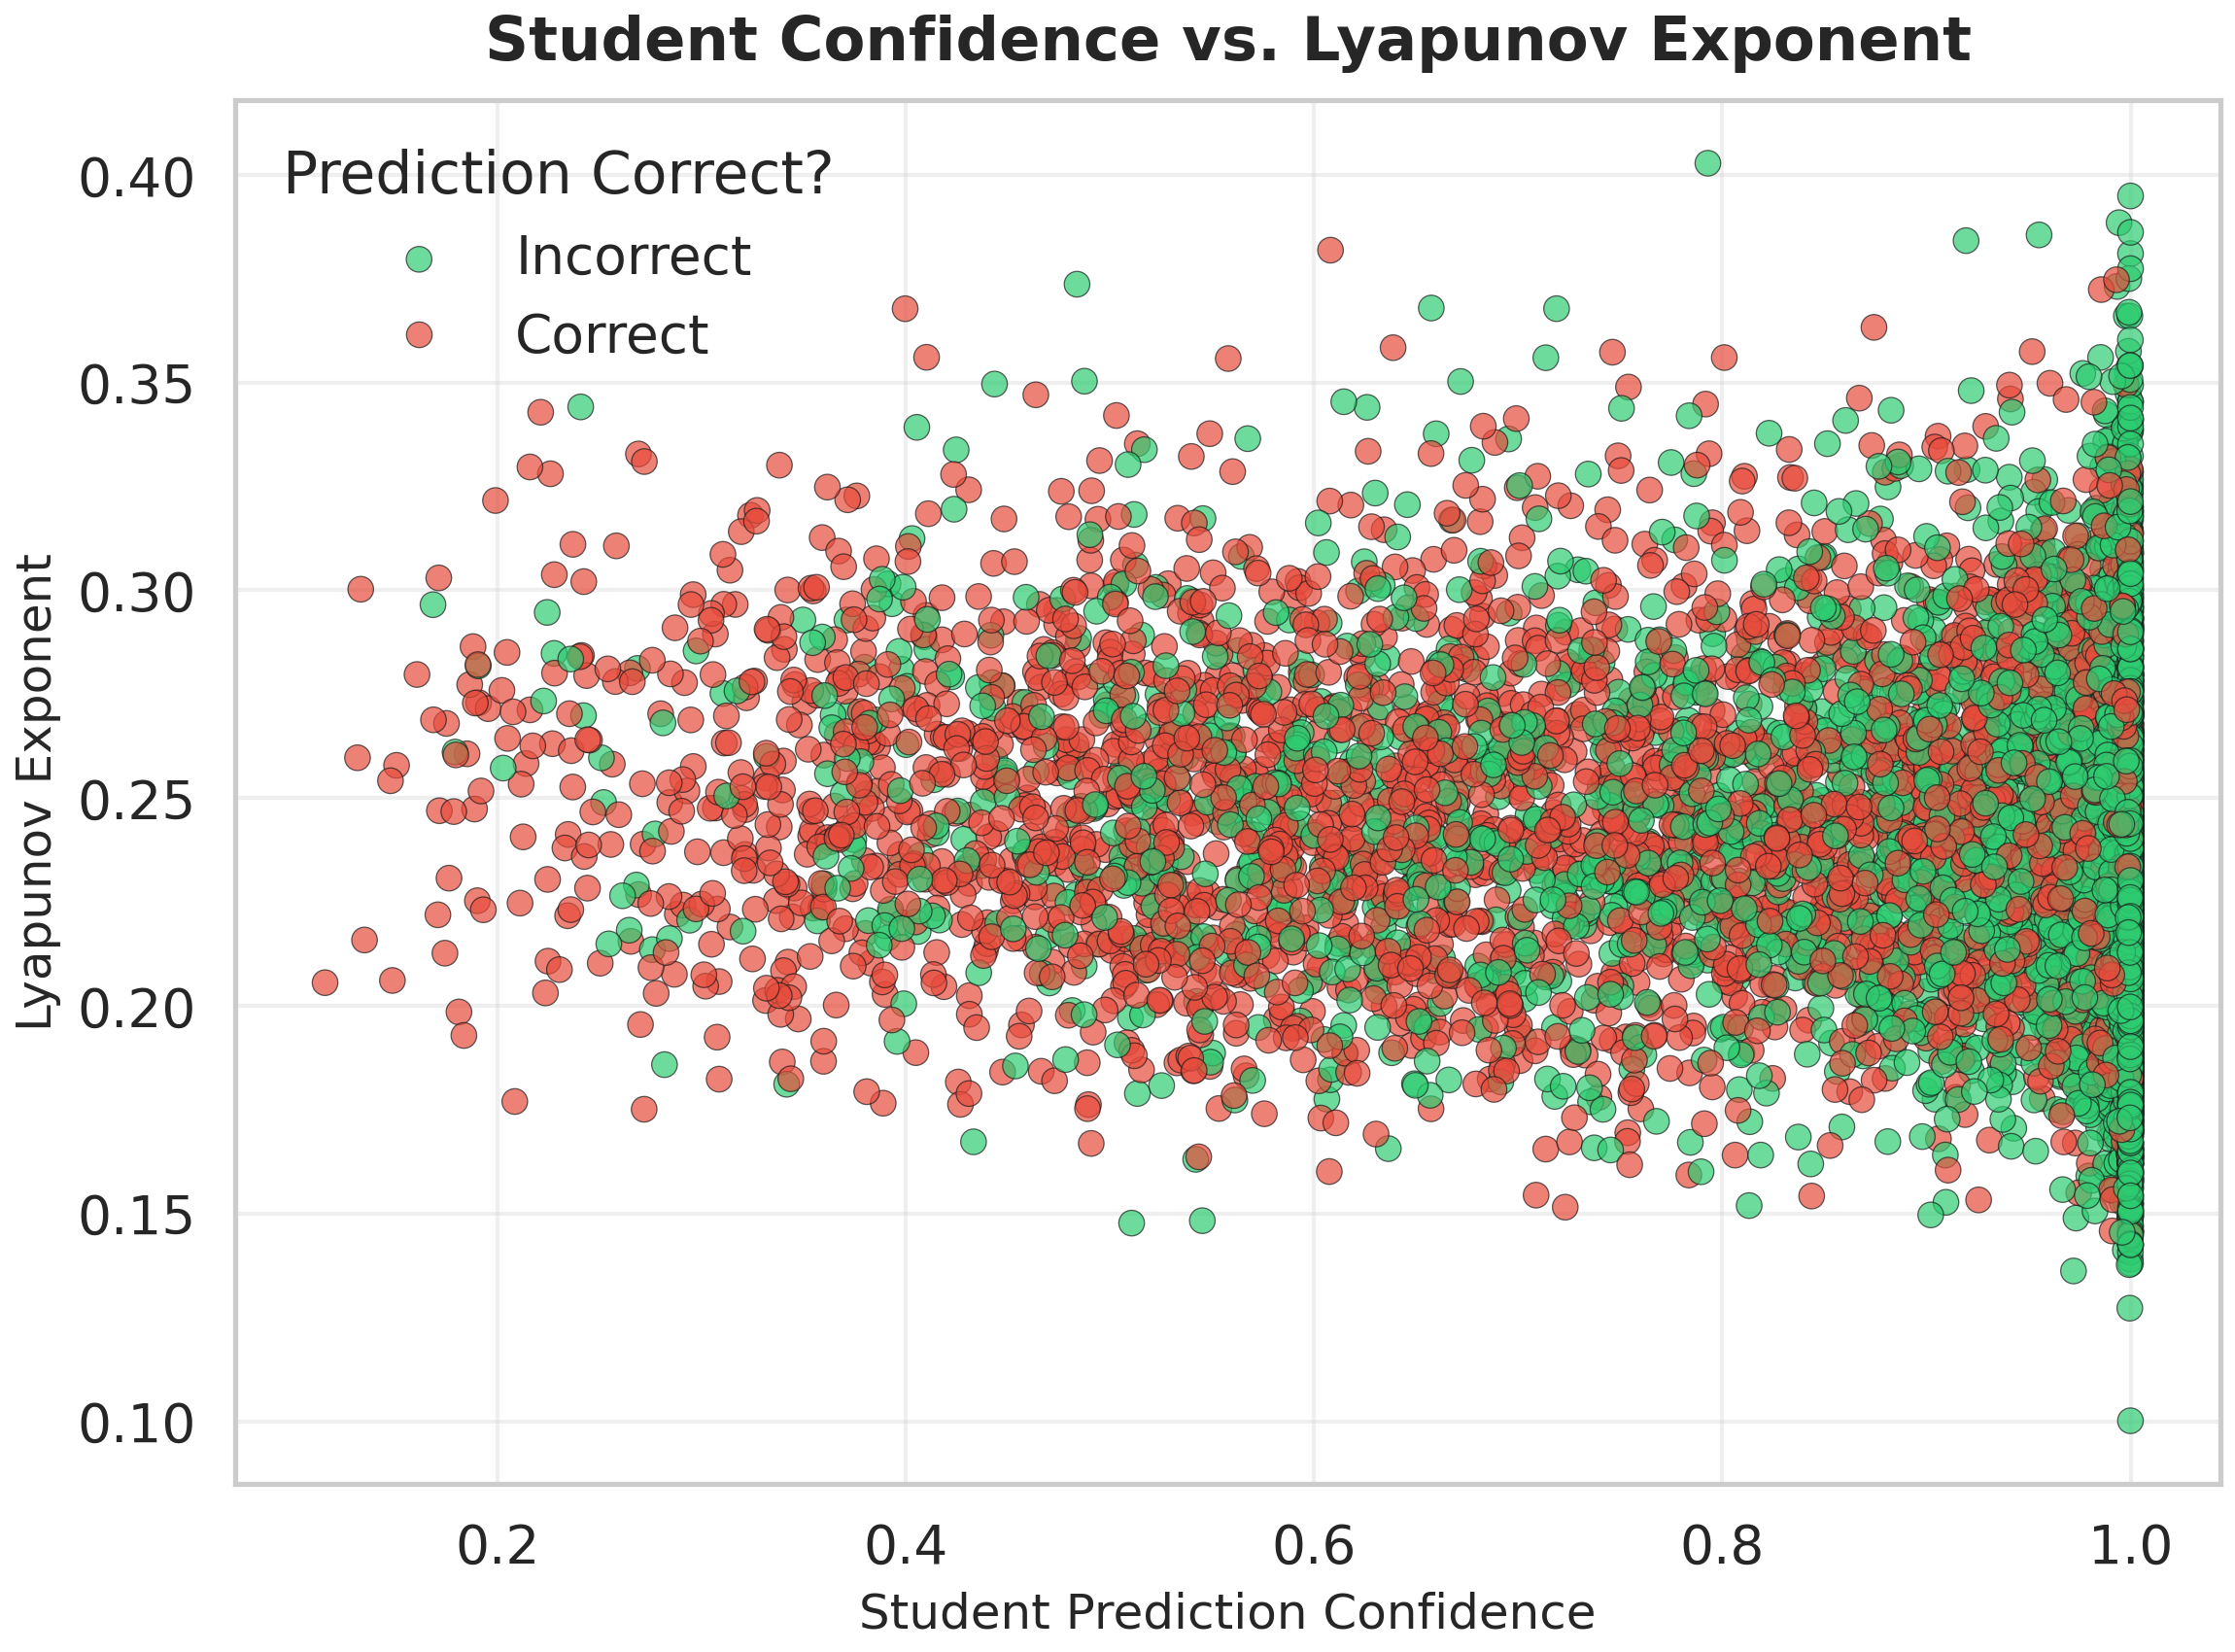

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8,6))

# Define color map for correctness
palette = {True: "#2ECC71", False: "#E74C3C"}  # green for correct, red for incorrect

# Scatter plot: confidence vs. Lyapunov
sns.scatterplot(
    data=df_samples,
    x="confidence",
    y="lyap",
    hue="correct",
    palette=palette,
    alpha=0.7,
    s=40,
    edgecolor="k",
    linewidth=0.3
)

# Add styling
plt.title("Student Confidence vs. Lyapunov Exponent", fontsize=15, weight="bold", pad=10)
plt.xlabel("Student Prediction Confidence", fontsize=12)
plt.ylabel("Lyapunov Exponent", fontsize=12)
plt.legend(title="Prediction Correct?", labels=["Incorrect", "Correct"])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Per Classes_

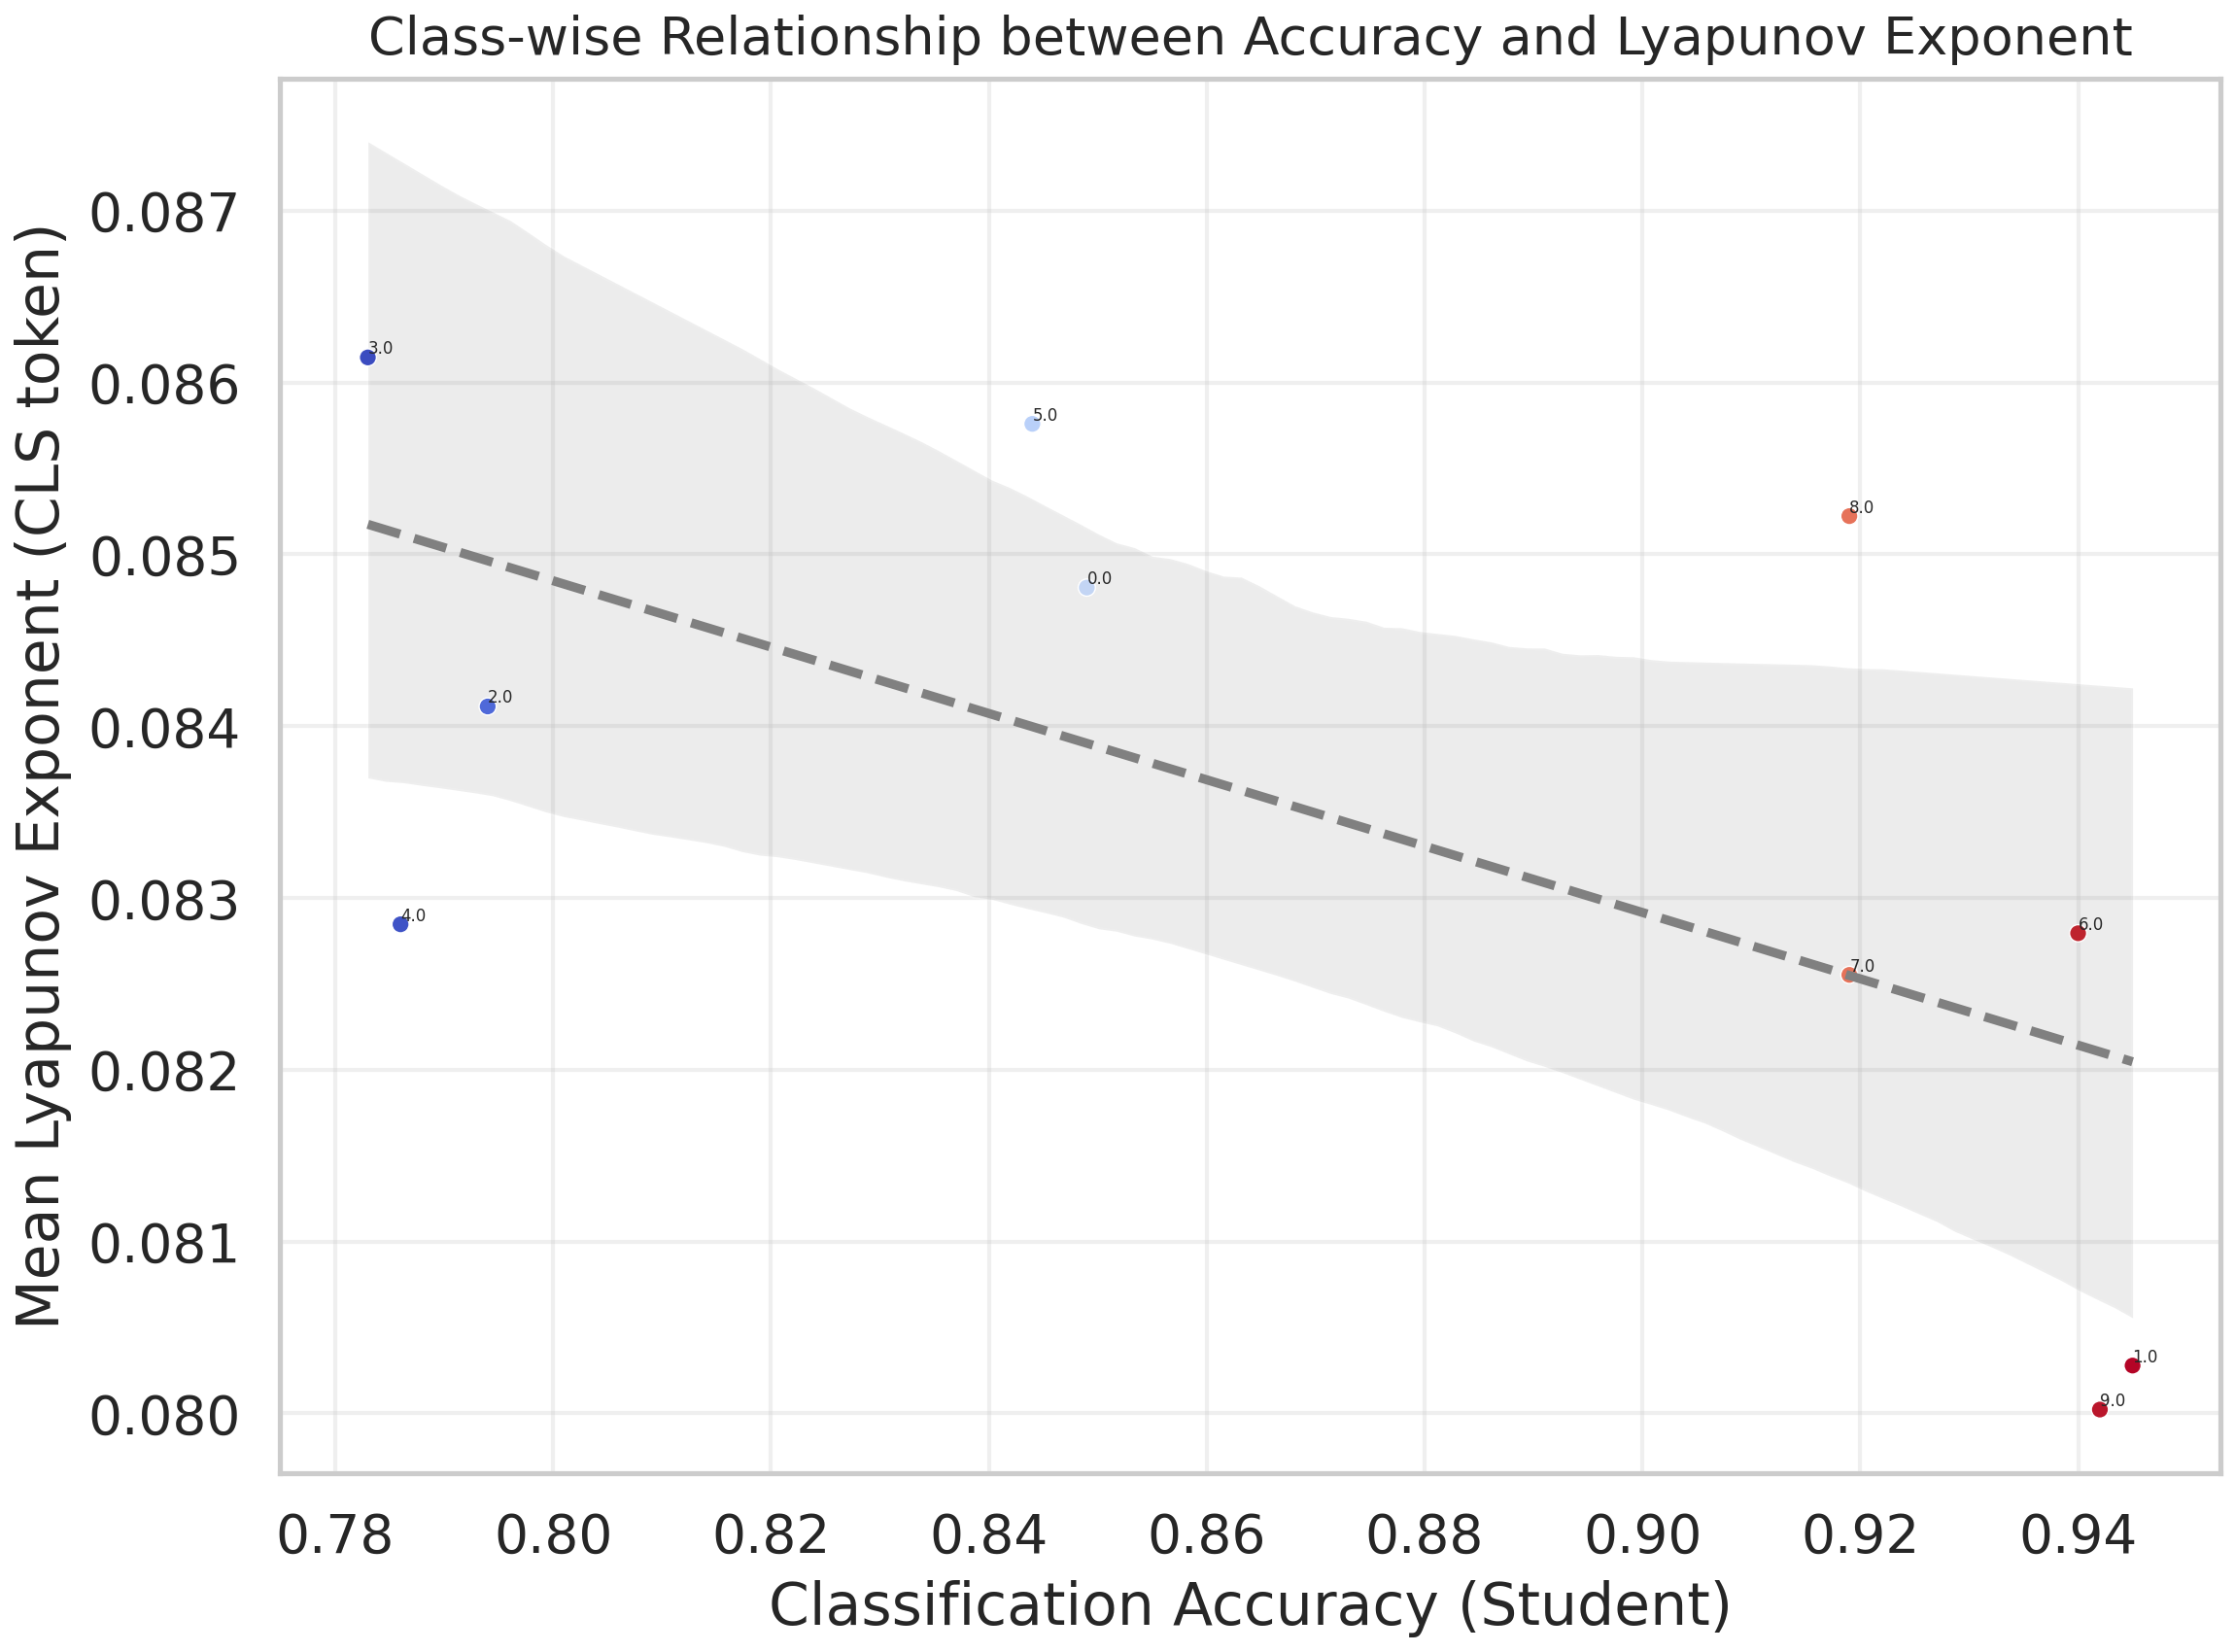

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build a dataframe
rows = []
for cls, vals in labels_prediction_lv.items():
    acc = sum(p_s == gt for _, p_s,  gt, _ in vals) / len(vals)
    mean_lyap = sum(l for *_, l in vals) / len(vals)
    rows.append({"class": cls, "accuracy": acc, "lyapunov": mean_lyap, "n": len(vals)})
df = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(8,6))
sns.regplot(data=df, x="accuracy", y="lyapunov", scatter=False, color="gray", line_kws={"linestyle":"--"})
sns.scatterplot(data=df, x="accuracy", y="lyapunov", size="n", hue="accuracy", palette="coolwarm", legend=False)

for _, row in df.iterrows():
    plt.text(row["accuracy"], row["lyapunov"], row["class"], fontsize=4, ha="left", va="bottom")

plt.title("Class-wise Relationship between Accuracy and Lyapunov Exponent", fontsize=13)
plt.xlabel("Classification Accuracy (Student)")
plt.ylabel("Mean Lyapunov Exponent (CLS token)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_575989/2120897641.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="acc_bin", y="lyapunov", palette="viridis")


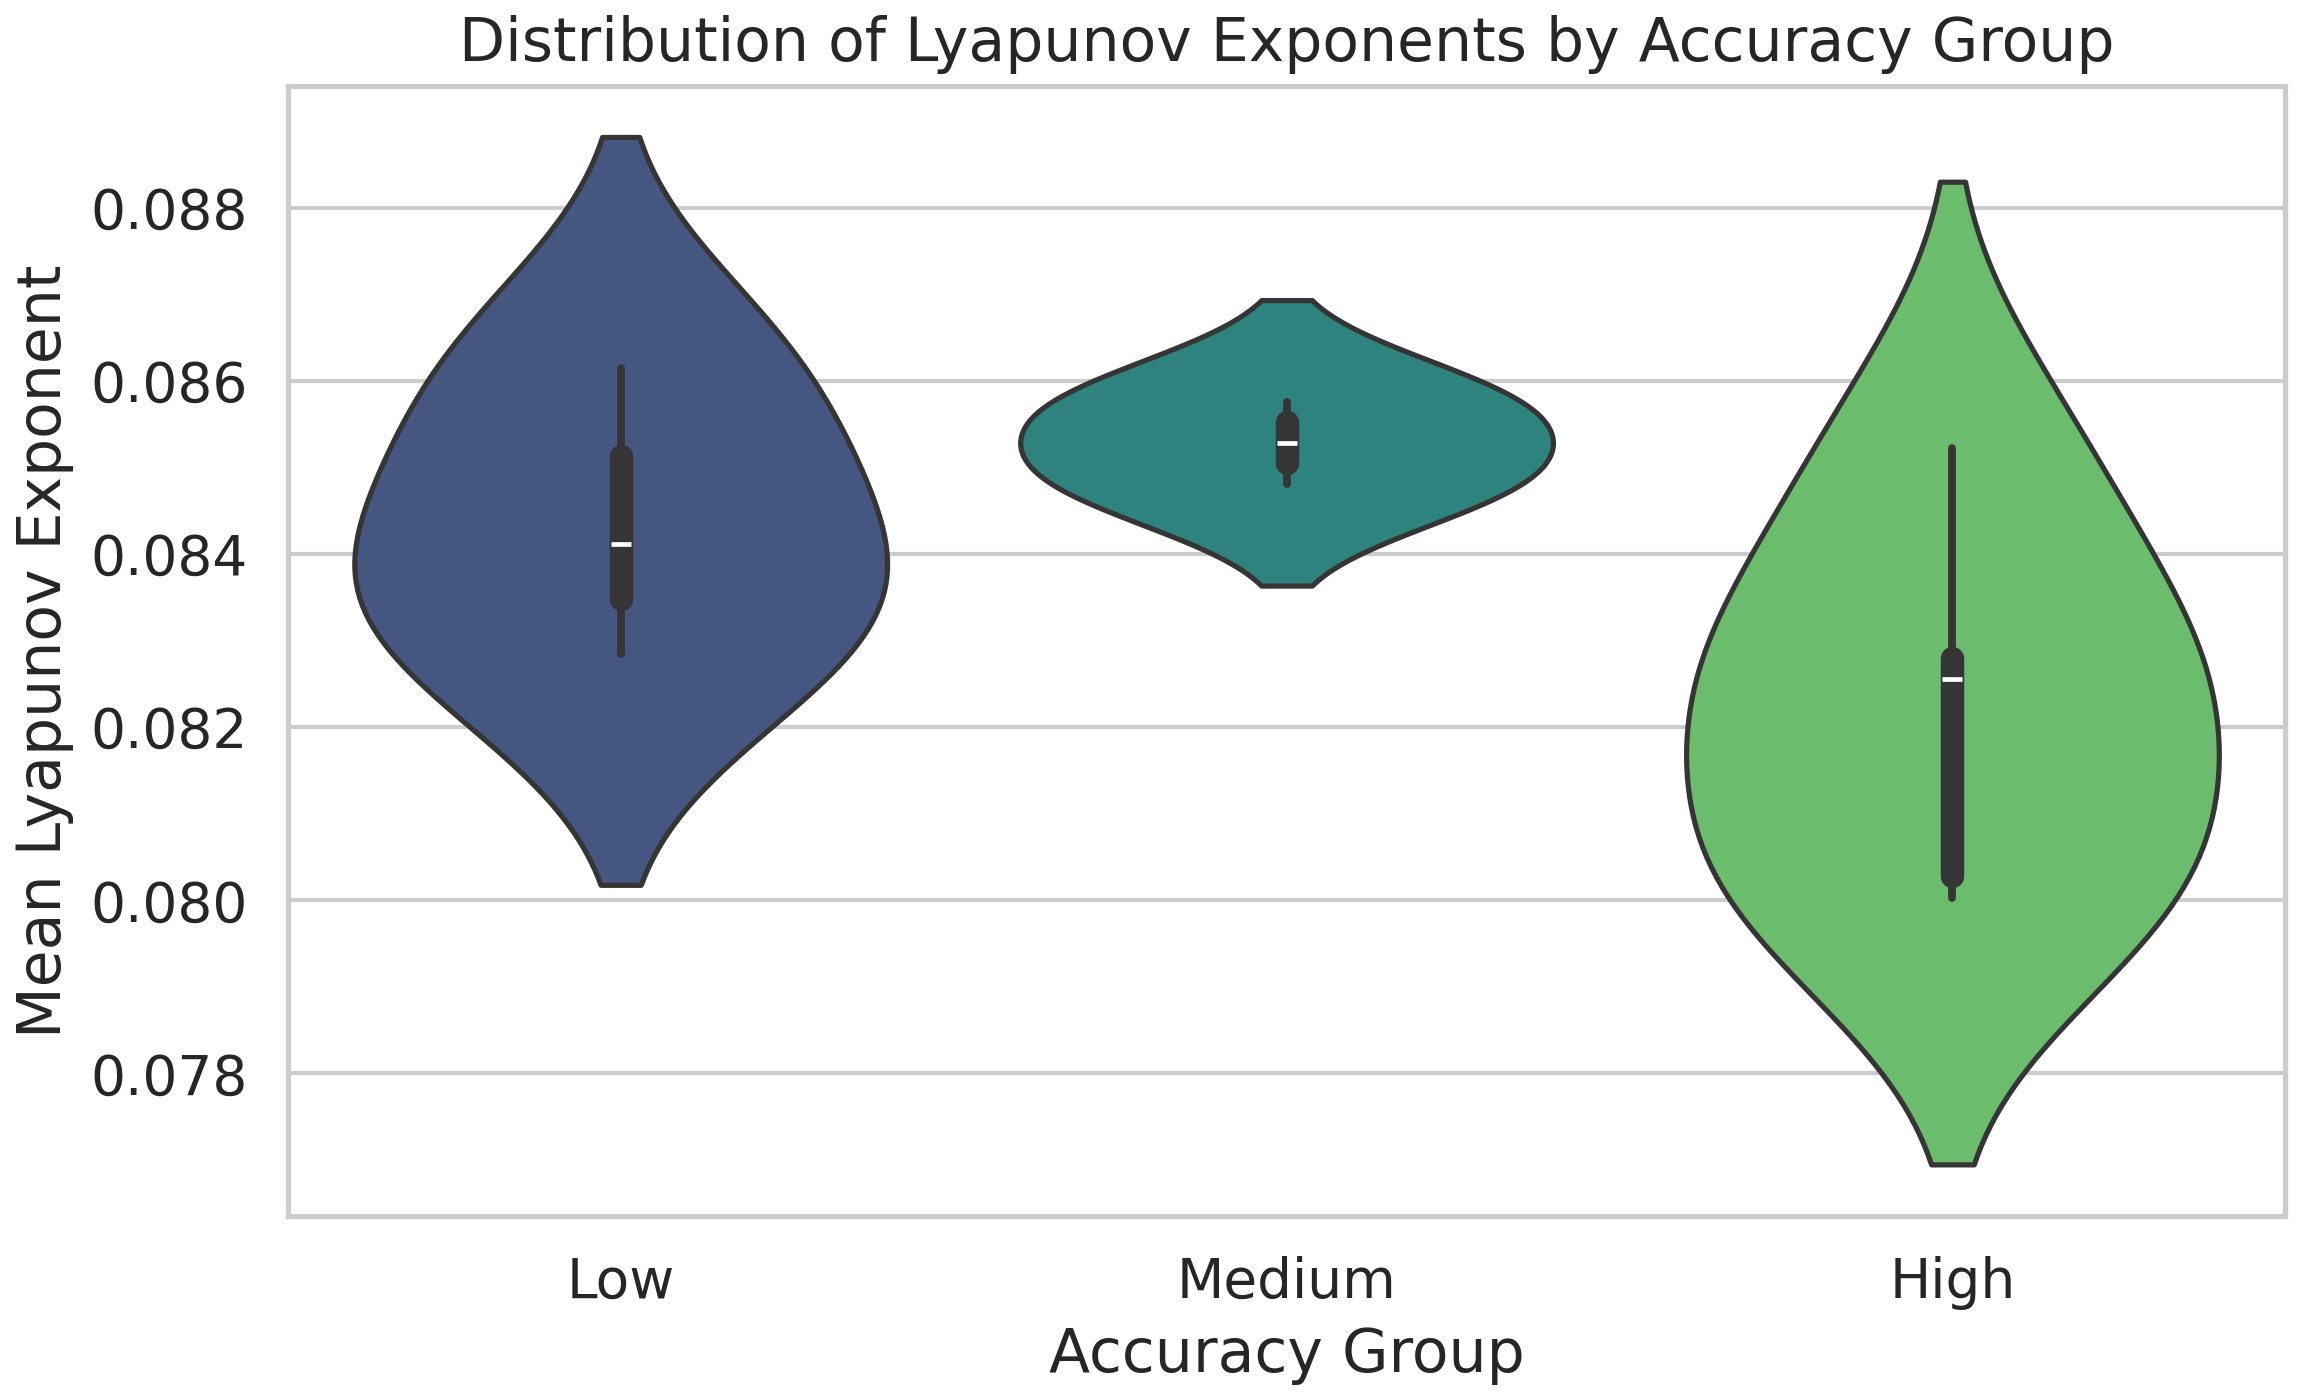

In [96]:
df["acc_bin"] = pd.cut(df["accuracy"], bins=[0.7,0.8,0.9,1.0], labels=["Low","Medium","High"])
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x="acc_bin", y="lyapunov", palette="viridis")
plt.title("Distribution of Lyapunov Exponents by Accuracy Group")
plt.xlabel("Accuracy Group")
plt.ylabel("Mean Lyapunov Exponent")
plt.tight_layout()
plt.show()

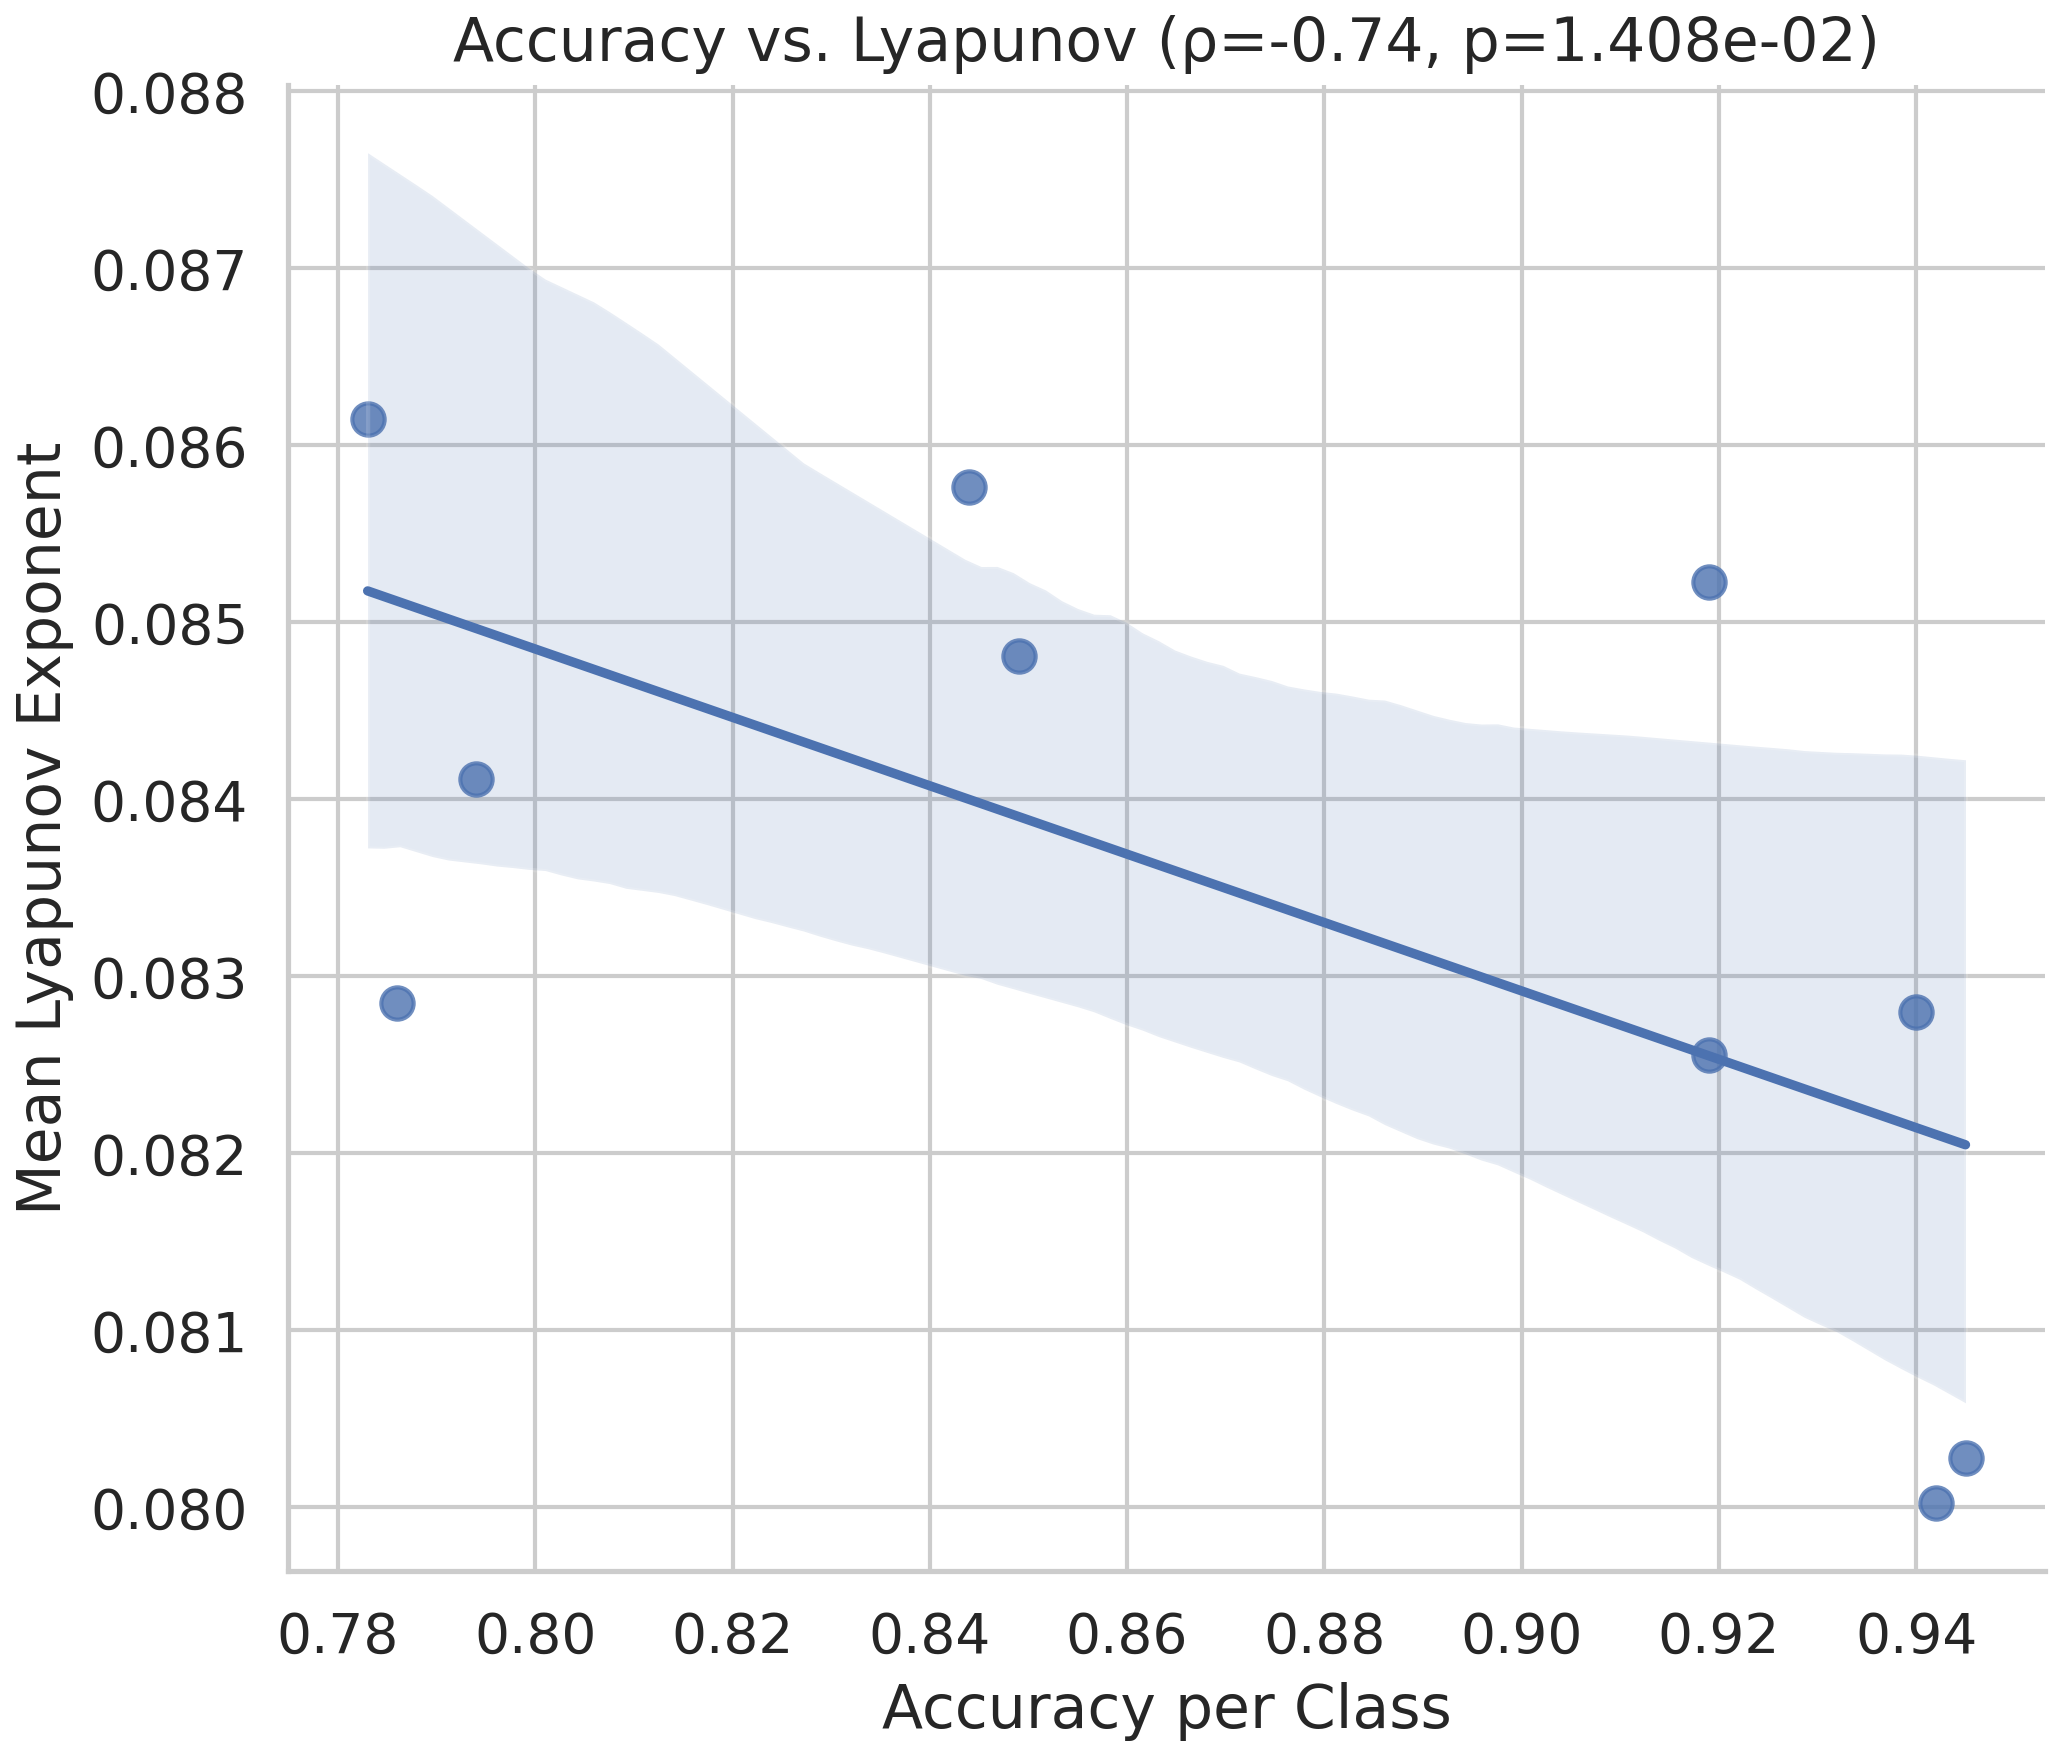

In [97]:
from scipy.stats import spearmanr

rho, pval = spearmanr(df["accuracy"], df["lyapunov"])
sns.lmplot(data=df, x="accuracy", y="lyapunov", height=6, aspect=1.2, scatter_kws={"s":60})
plt.title(f"Accuracy vs. Lyapunov (ρ={rho:.2f}, p={pval:.3e})")
plt.xlabel("Accuracy per Class")
plt.ylabel("Mean Lyapunov Exponent")
plt.show()

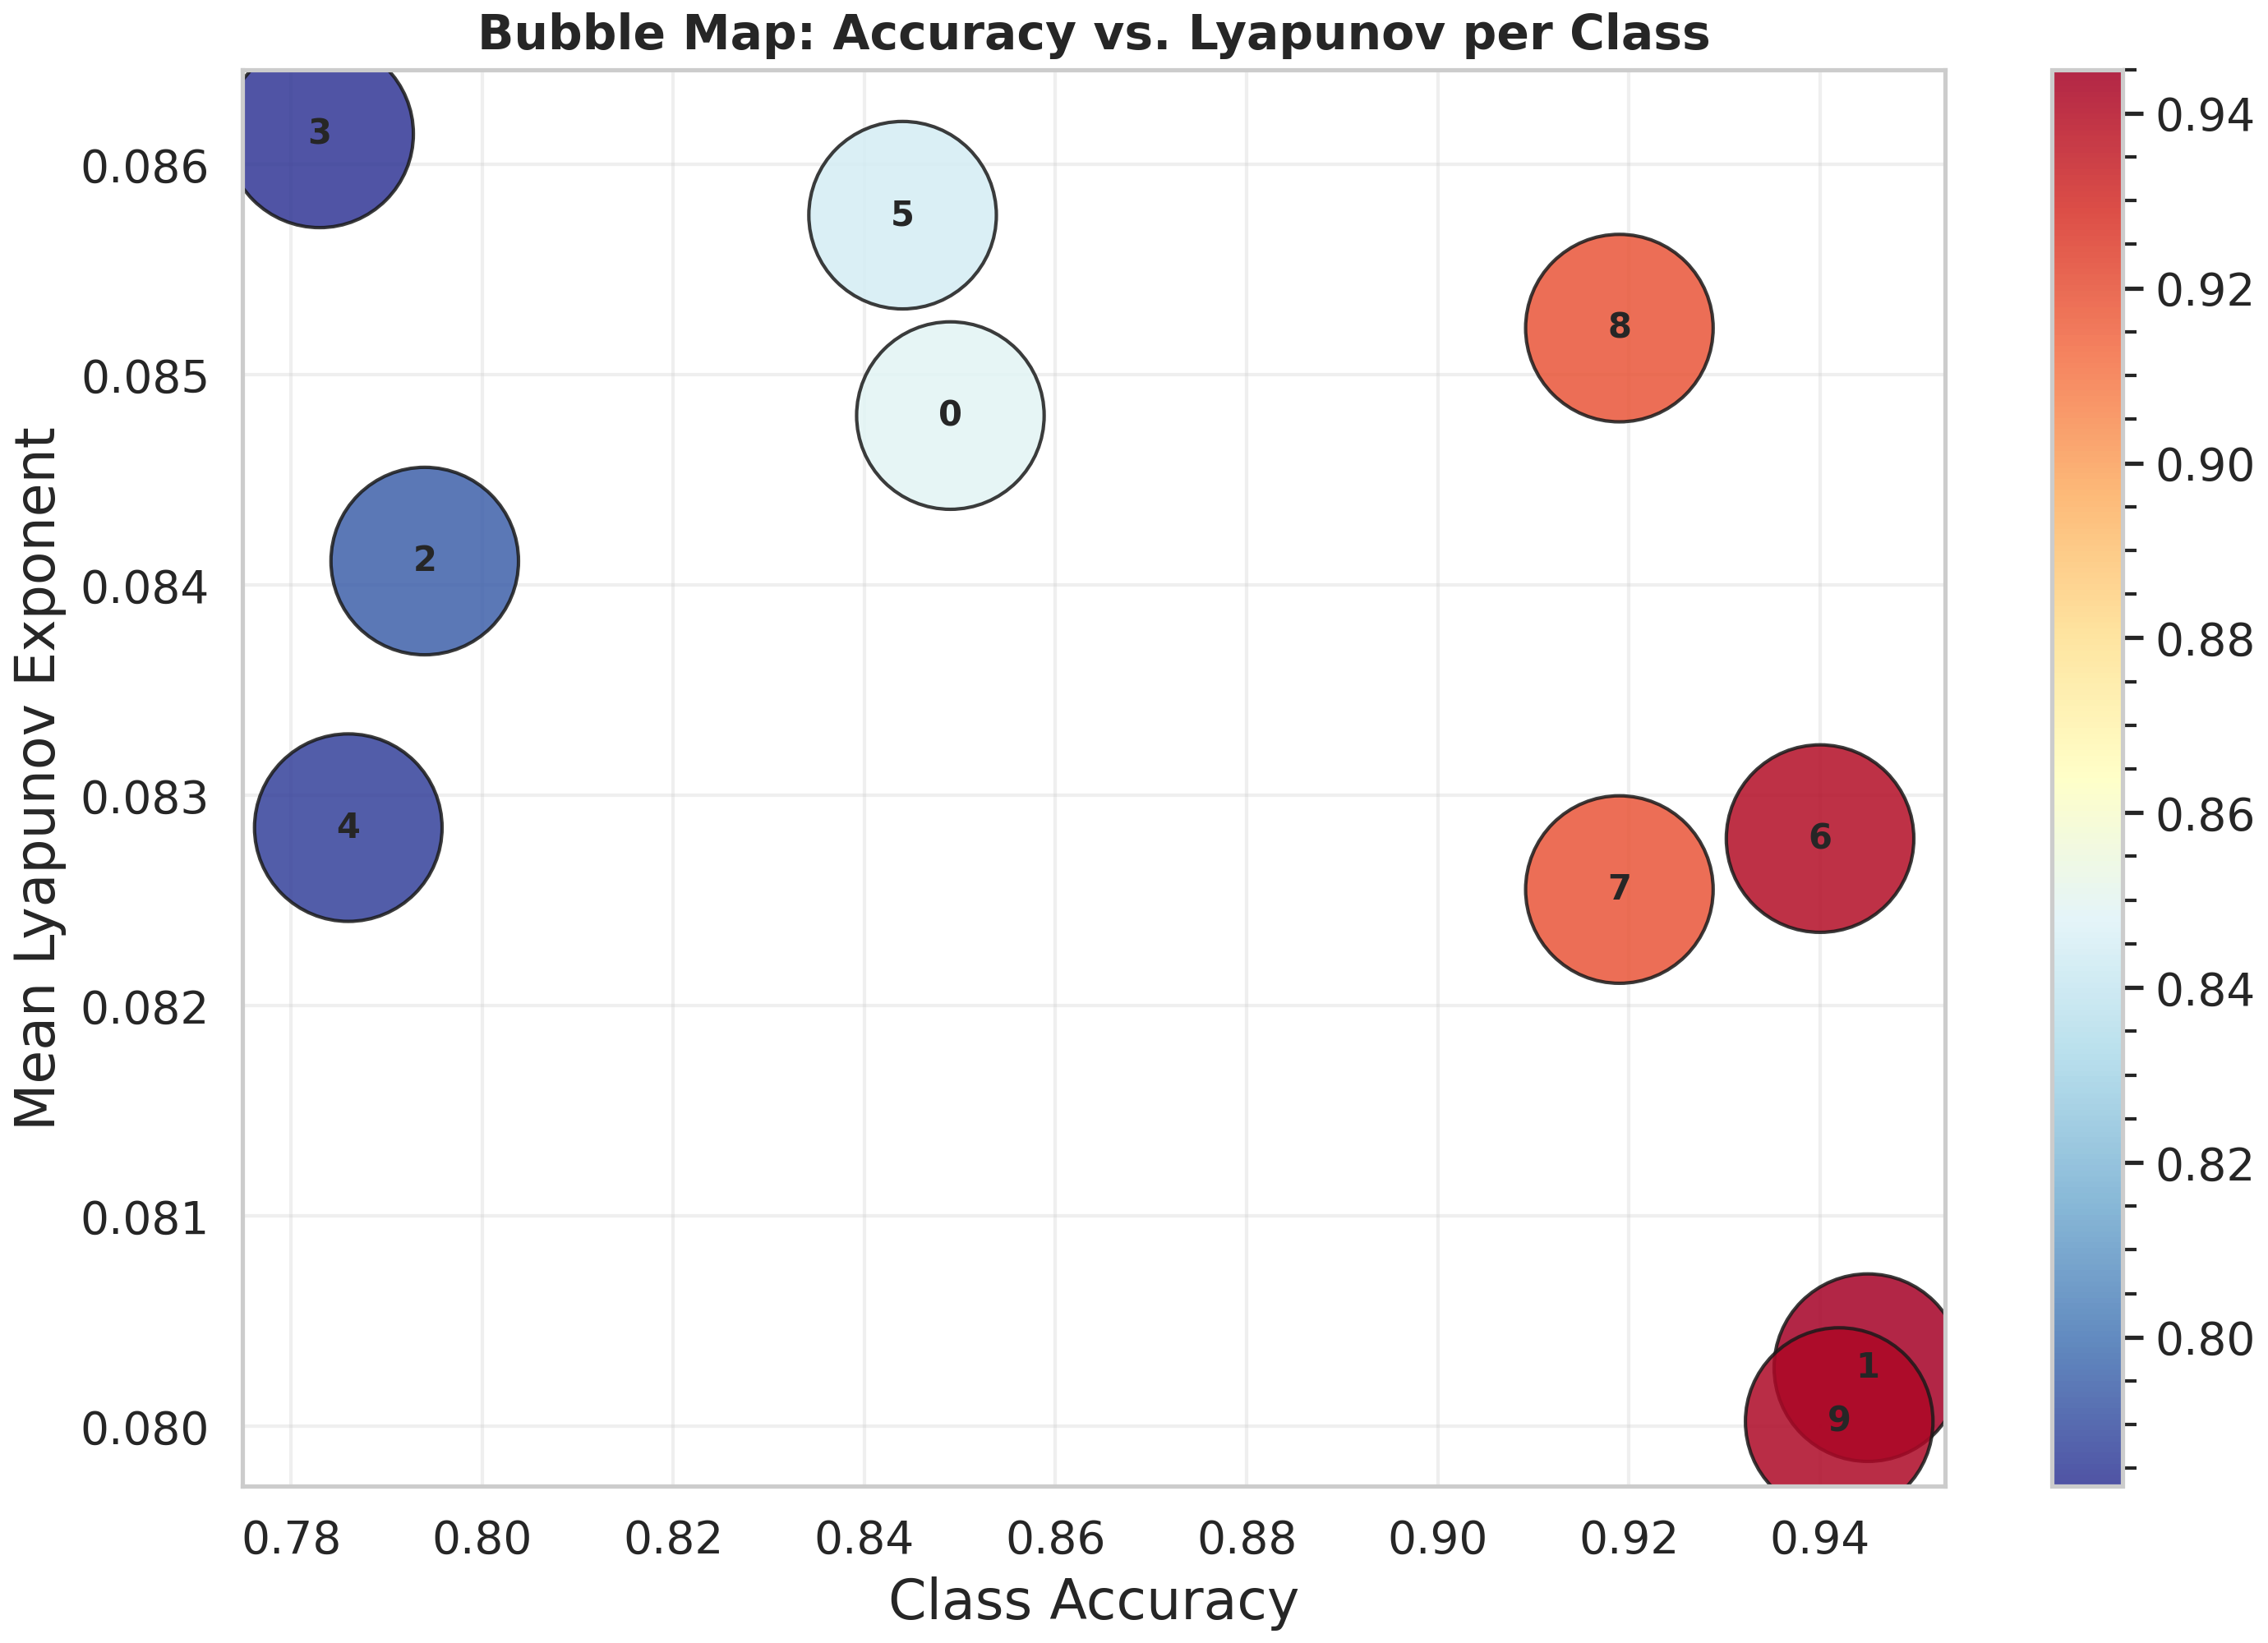

In [99]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))

sc = plt.scatter(
    df["accuracy"], df["lyapunov"],
    s=df["n"]*3,
    c=df["accuracy"],
    cmap="RdYlBu_r",
    edgecolor="k",
    alpha=0.85
)

texts = []
for _, row in df.iterrows():
    if row["accuracy"] < 0.5 or row["accuracy"] > 0.7:
        txt = plt.text(
            row["accuracy"], row["lyapunov"],
            str(int(row["class"])),
            fontsize=10,
            fontweight="bold",
            ha="center",
            va="center",
        )
        texts.append(txt)

# --- Smart adjustment ---

# --- Colorbar and labels ---
cbar = plt.colorbar(sc)
plt.xlabel("Class Accuracy", fontsize=16)
plt.ylabel("Mean Lyapunov Exponent", fontsize=16)
plt.title("Bubble Map: Accuracy vs. Lyapunov per Class", fontsize=14, weight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd
import numpy as np

rows = []
for cls, vals in labels_prediction_lv.items():
    lyaps = np.array([l for *_, l in vals])
    preds_T = np.array([t for t, _, _, _, _ in vals])
    preds_S = np.array([s for _, s, _, _, _ in vals])
    gts = np.array([g for _, _, _,  g, _ in vals])

    acc_S = np.mean(preds_S == gts)
    acc_T = np.mean(preds_T == gts)
    mean_lyap = np.mean(lyaps)
    std_lyap = np.std(lyaps)
    lyap_fail = np.mean(lyaps[preds_S != gts]) 
    lyap_succ = np.mean(lyaps[preds_S == gts]) 
    rows.append({
        "class": cls,
        "acc_student": acc_S,
        "acc_teacher": acc_T,
        "mean_lyap": mean_lyap,
        "std_lyap": std_lyap,
        "lyap_fail": lyap_fail,
        "lyap_succ": lyap_succ,
        "n": len(vals)
    })

df = pd.DataFrame(rows)


/tmp/ipykernel_3315229/3225868875.py:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/cboned/miniconda3/envs/graphocr/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


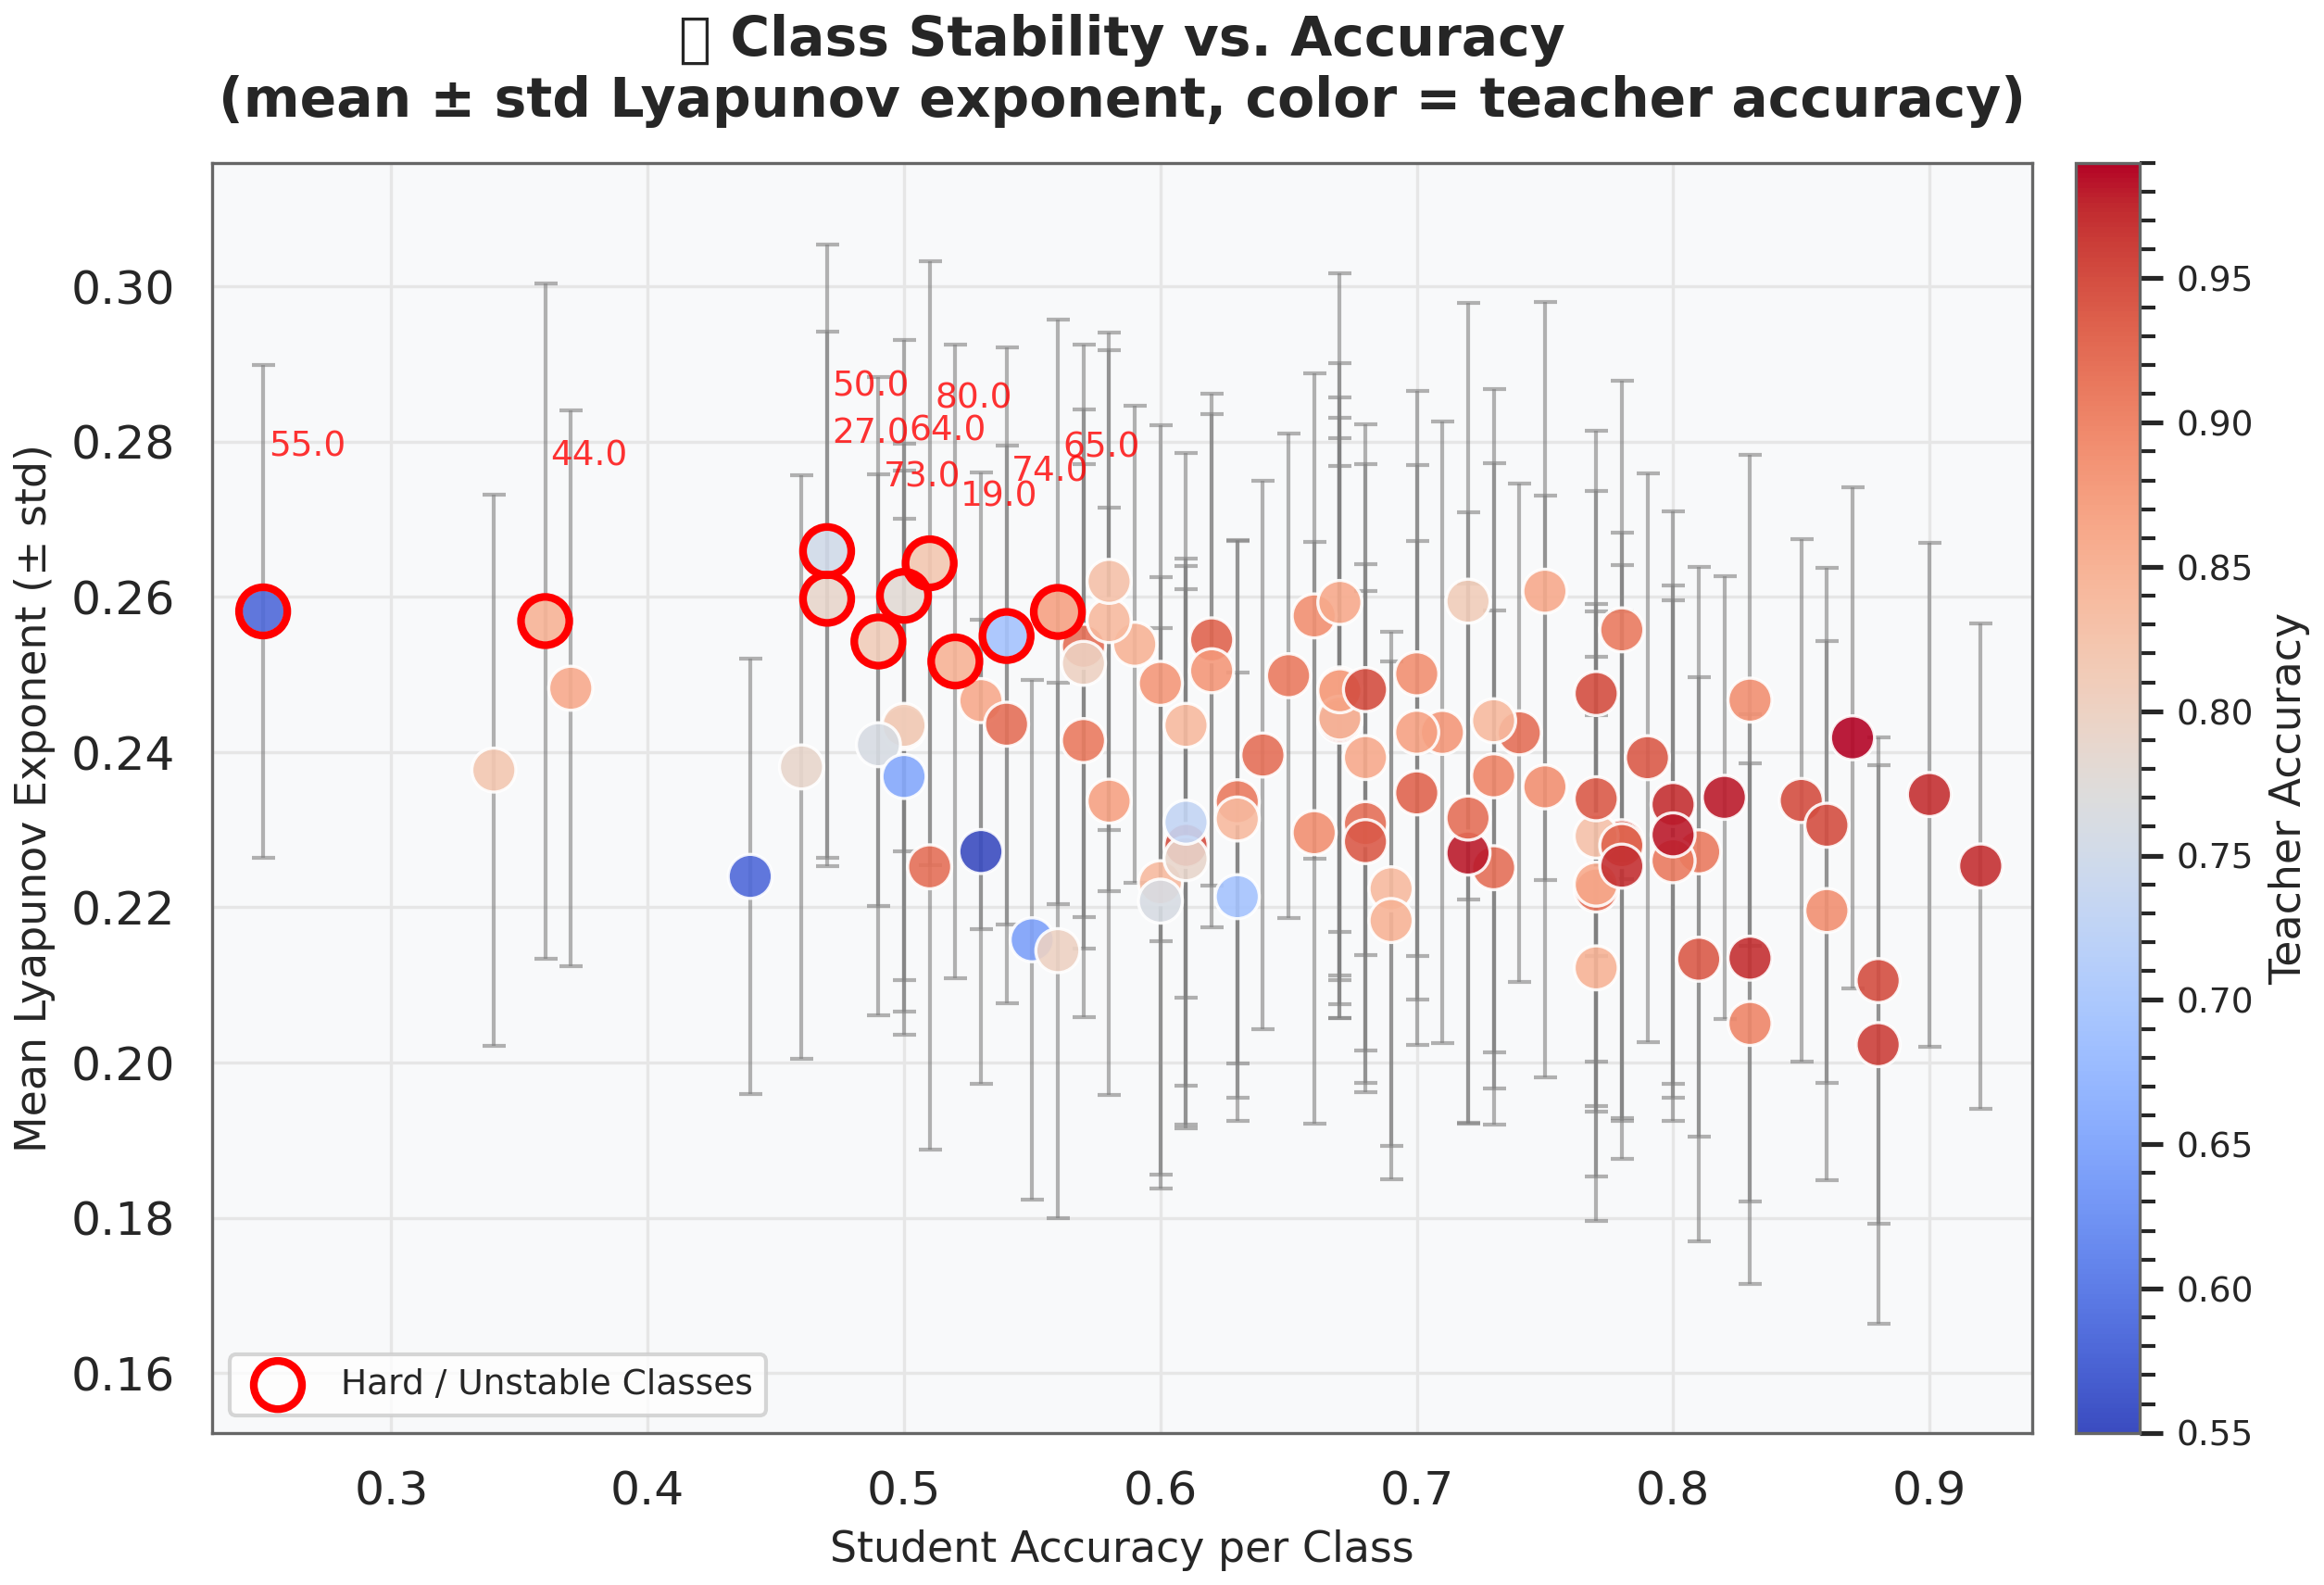

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- General style ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["axes.edgecolor"] = "0.4"
plt.rcParams["axes.linewidth"] = 0.8

# --- Figure and color normalization ---
fig, ax = plt.subplots(figsize=(9, 6))
norm = plt.Normalize(df["acc_teacher"].min(), df["acc_teacher"].max())
cmap = plt.cm.coolwarm
colors = cmap(norm(df["acc_teacher"]))

# --- Bubble scatter with transparency and subtle edge highlight ---
sc = ax.scatter(
    df["acc_student"], df["mean_lyap"],
    s=100 * (df["n"] / df["n"].max() + 0.3),  # scaled size for visibility
    c=colors, edgecolor="white", linewidth=0.8,
    alpha=0.9, zorder=3
)

# --- Error bars (std of Lyapunov) ---
ax.errorbar(
    df["acc_student"], df["mean_lyap"], yerr=df["std_lyap"],
    fmt='none', ecolor='gray', elinewidth=1, capsize=3, alpha=0.6, zorder=1
)

# --- Highlight low-accuracy, high-Lyapunov classes ---
thr_acc = np.percentile(df["acc_student"], 25)
thr_lyap = np.percentile(df["mean_lyap"], 75)
mask_high = (df["acc_student"] < thr_acc) & (df["mean_lyap"] > thr_lyap)

ax.scatter(
    df.loc[mask_high, "acc_student"], df.loc[mask_high, "mean_lyap"],
    s=120 * (df.loc[mask_high, "n"] / df["n"].max() + 0.3),
    facecolors='none', edgecolors='red', linewidths=2, zorder=4,
    label="Hard / Unstable Classes"
)

# --- Annotate selected extreme points only ---
for _, row in df.loc[mask_high].iterrows():
    ax.text(row["acc_student"] + 0.002, row["mean_lyap"] + 0.02,
            row["class"], fontsize=9, weight="medium", color="red", alpha=0.8)

# --- Colorbar with improved design ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Teacher Accuracy", fontsize=11)
cbar.ax.tick_params(labelsize=9)

# --- Titles and labels ---
ax.set_title("📈 Class Stability vs. Accuracy\n(mean ± std Lyapunov exponent, color = teacher accuracy)",
             fontsize=14, pad=12, weight="semibold")
ax.set_xlabel("Student Accuracy per Class", fontsize=11)
ax.set_ylabel("Mean Lyapunov Exponent (± std)", fontsize=11)

# --- Grid, background, limits ---
ax.set_facecolor("#f8f9fa")
ax.grid(True, which="major", color="#e6e6e6", linewidth=0.8)
ax.set_xlim(df["acc_student"].min() - 0.02, df["acc_student"].max() + 0.02)
ax.set_ylim(df["mean_lyap"].min() - 0.05, df["mean_lyap"].max() + 0.05)



# --- Legend placement ---
ax.legend(frameon=True, loc="lower left", fontsize=9)

# --- Tight layout ---
plt.tight_layout()
plt.show()



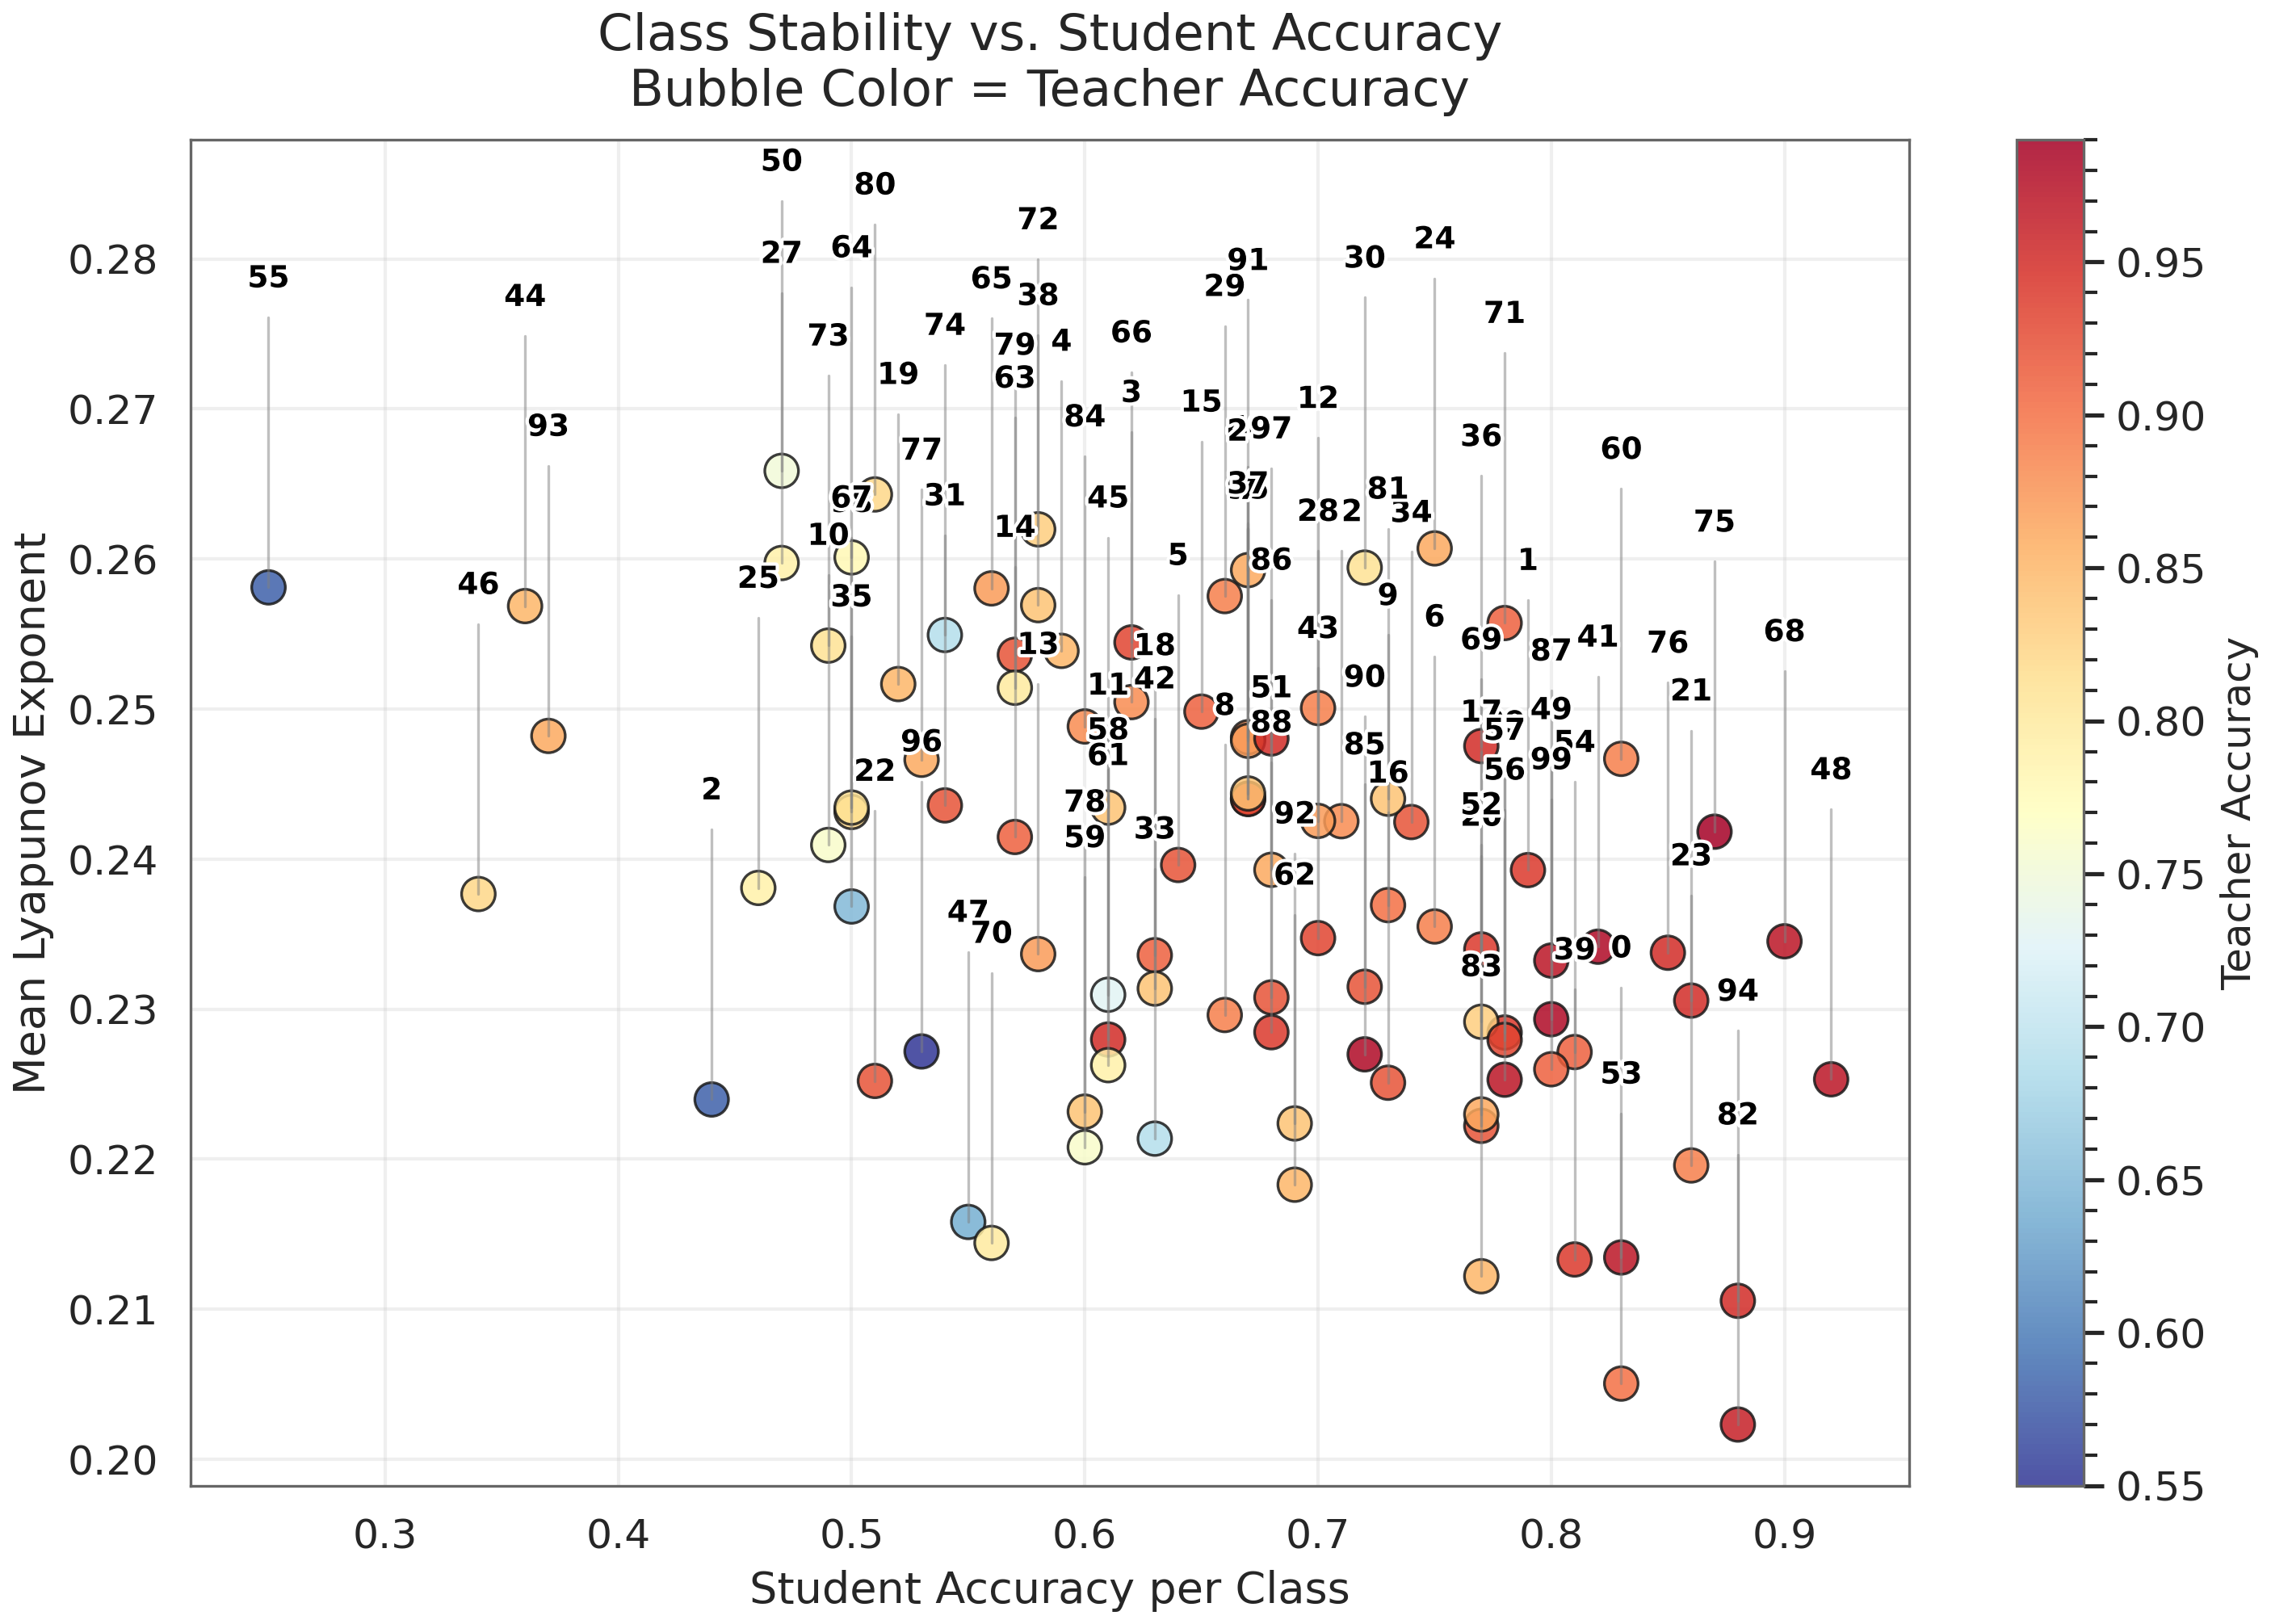

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

plt.figure(figsize=(10,7))

# Normalize teacher accuracy for color
norm = plt.Normalize(df["acc_teacher"].min(), df["acc_teacher"].max())
cmap = plt.cm.RdYlBu_r

# --- Scatter ---
sc = plt.scatter(
    df["acc_student"], df["mean_lyap"],
    s=df["n"],  # bigger bubbles
    c=df["acc_teacher"],
    cmap=cmap, norm=norm,
    edgecolor="k", linewidth=0.8,
    alpha=0.85
)

# --- Annotate each bubble ---
for _, row in df.iterrows():
    plt.text(
        row["acc_student"],
        row["mean_lyap"] + 0.02,  # vertical offset to avoid overlap
        str(int(row["class"])),
        fontsize=9, fontweight="bold", color="black",
        ha="center",
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]  # outline for contrast
    )

# --- Optional connecting line for crowded points ---
# (Helps show which label belongs to which bubble)
for _, row in df.iterrows():
    plt.plot(
        [row["acc_student"], row["acc_student"]],
        [row["mean_lyap"], row["mean_lyap"] + 0.018],
        color="gray", linewidth=0.8, alpha=0.5
    )

# --- Colorbar ---
cbar = plt.colorbar(sc)
cbar.set_label("Teacher Accuracy", fontsize=12)

# --- Labels, title, grid ---
plt.xlabel("Student Accuracy per Class", fontsize=13)
plt.ylabel("Mean Lyapunov Exponent", fontsize=13)
plt.title("Class Stability vs. Student Accuracy\nBubble Color = Teacher Accuracy", fontsize=15, pad=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


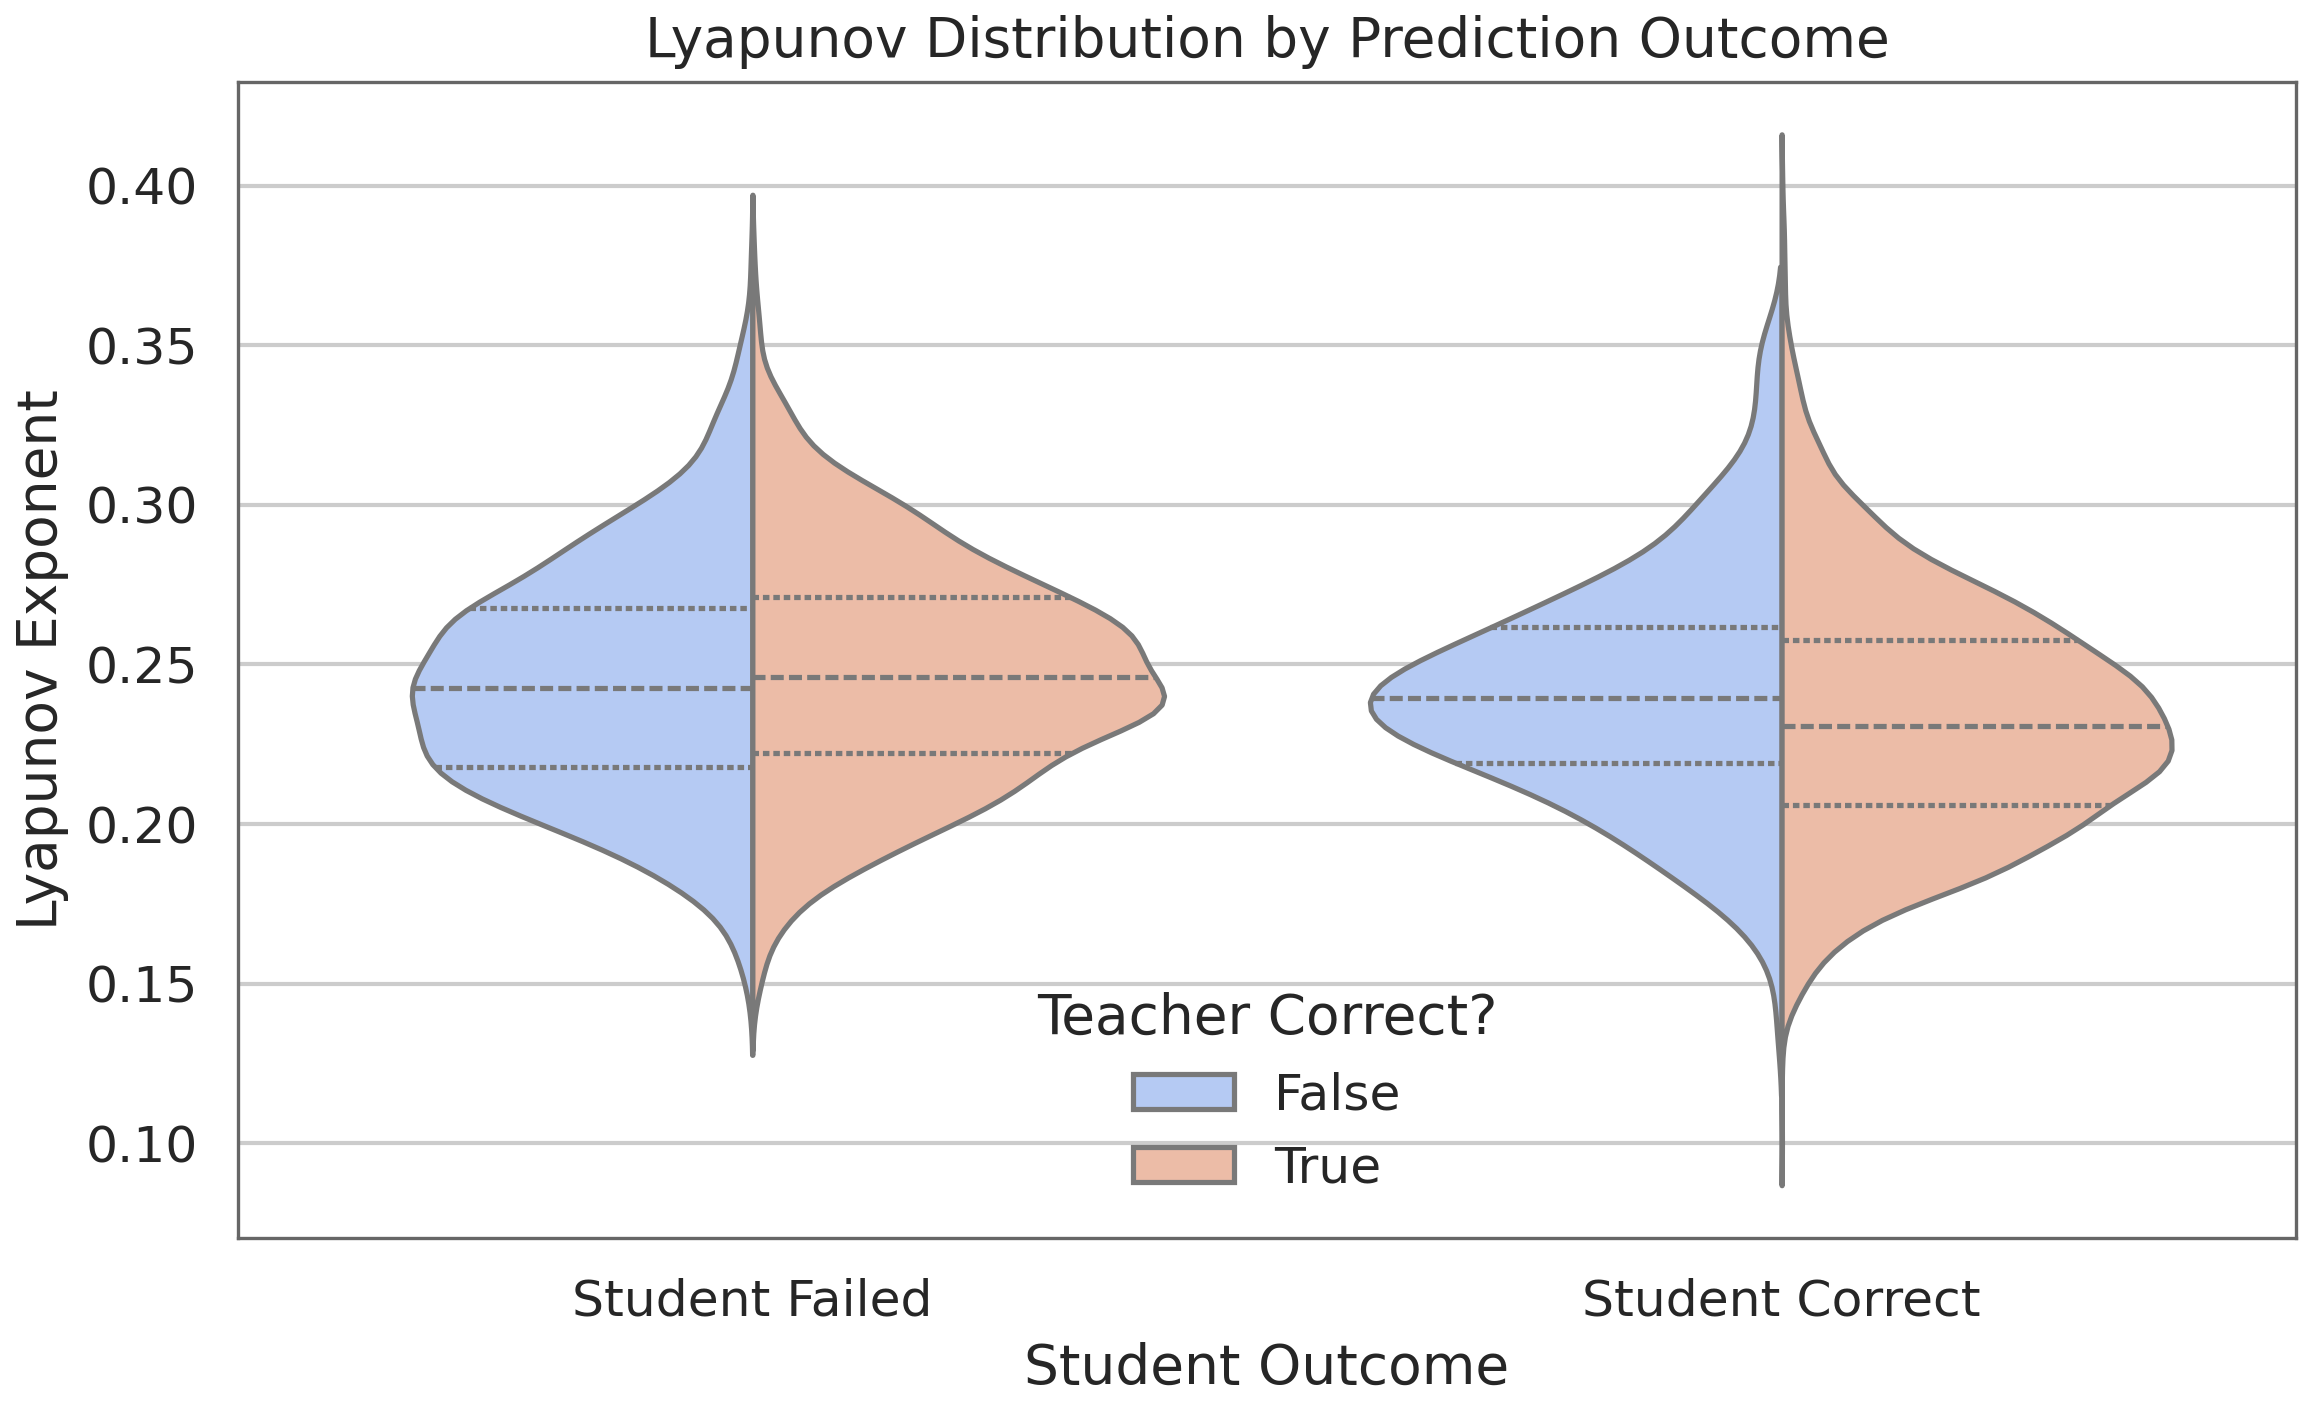

In [46]:
import seaborn as sns

# explode all samples into long form
flat = []
for cls, vals in labels_prediction_lv.items():
    for t, s, conf, g, l in vals:
        flat.append({
            "class": cls,
            "correct": s == g,
            "teacher_correct": t == g,
            "lyap": l
        })
df_long = pd.DataFrame(flat)

plt.figure(figsize=(8,5))
sns.violinplot(data=df_long, x="correct", y="lyap", hue="teacher_correct",
               split=True, inner="quartile", palette="coolwarm")
plt.xticks([0,1], ["Student Failed", "Student Correct"])
plt.title("Lyapunov Distribution by Prediction Outcome")
plt.ylabel("Lyapunov Exponent")
plt.xlabel("Student Outcome")
plt.legend(title="Teacher Correct?")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3315229/1770231309.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_long, x="case_label", y="lyap", palette="viridis", ci="sd")
/tmp/ipykernel_3315229/1770231309.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_long, x="case_label", y="lyap", palette="viridis", ci="sd")


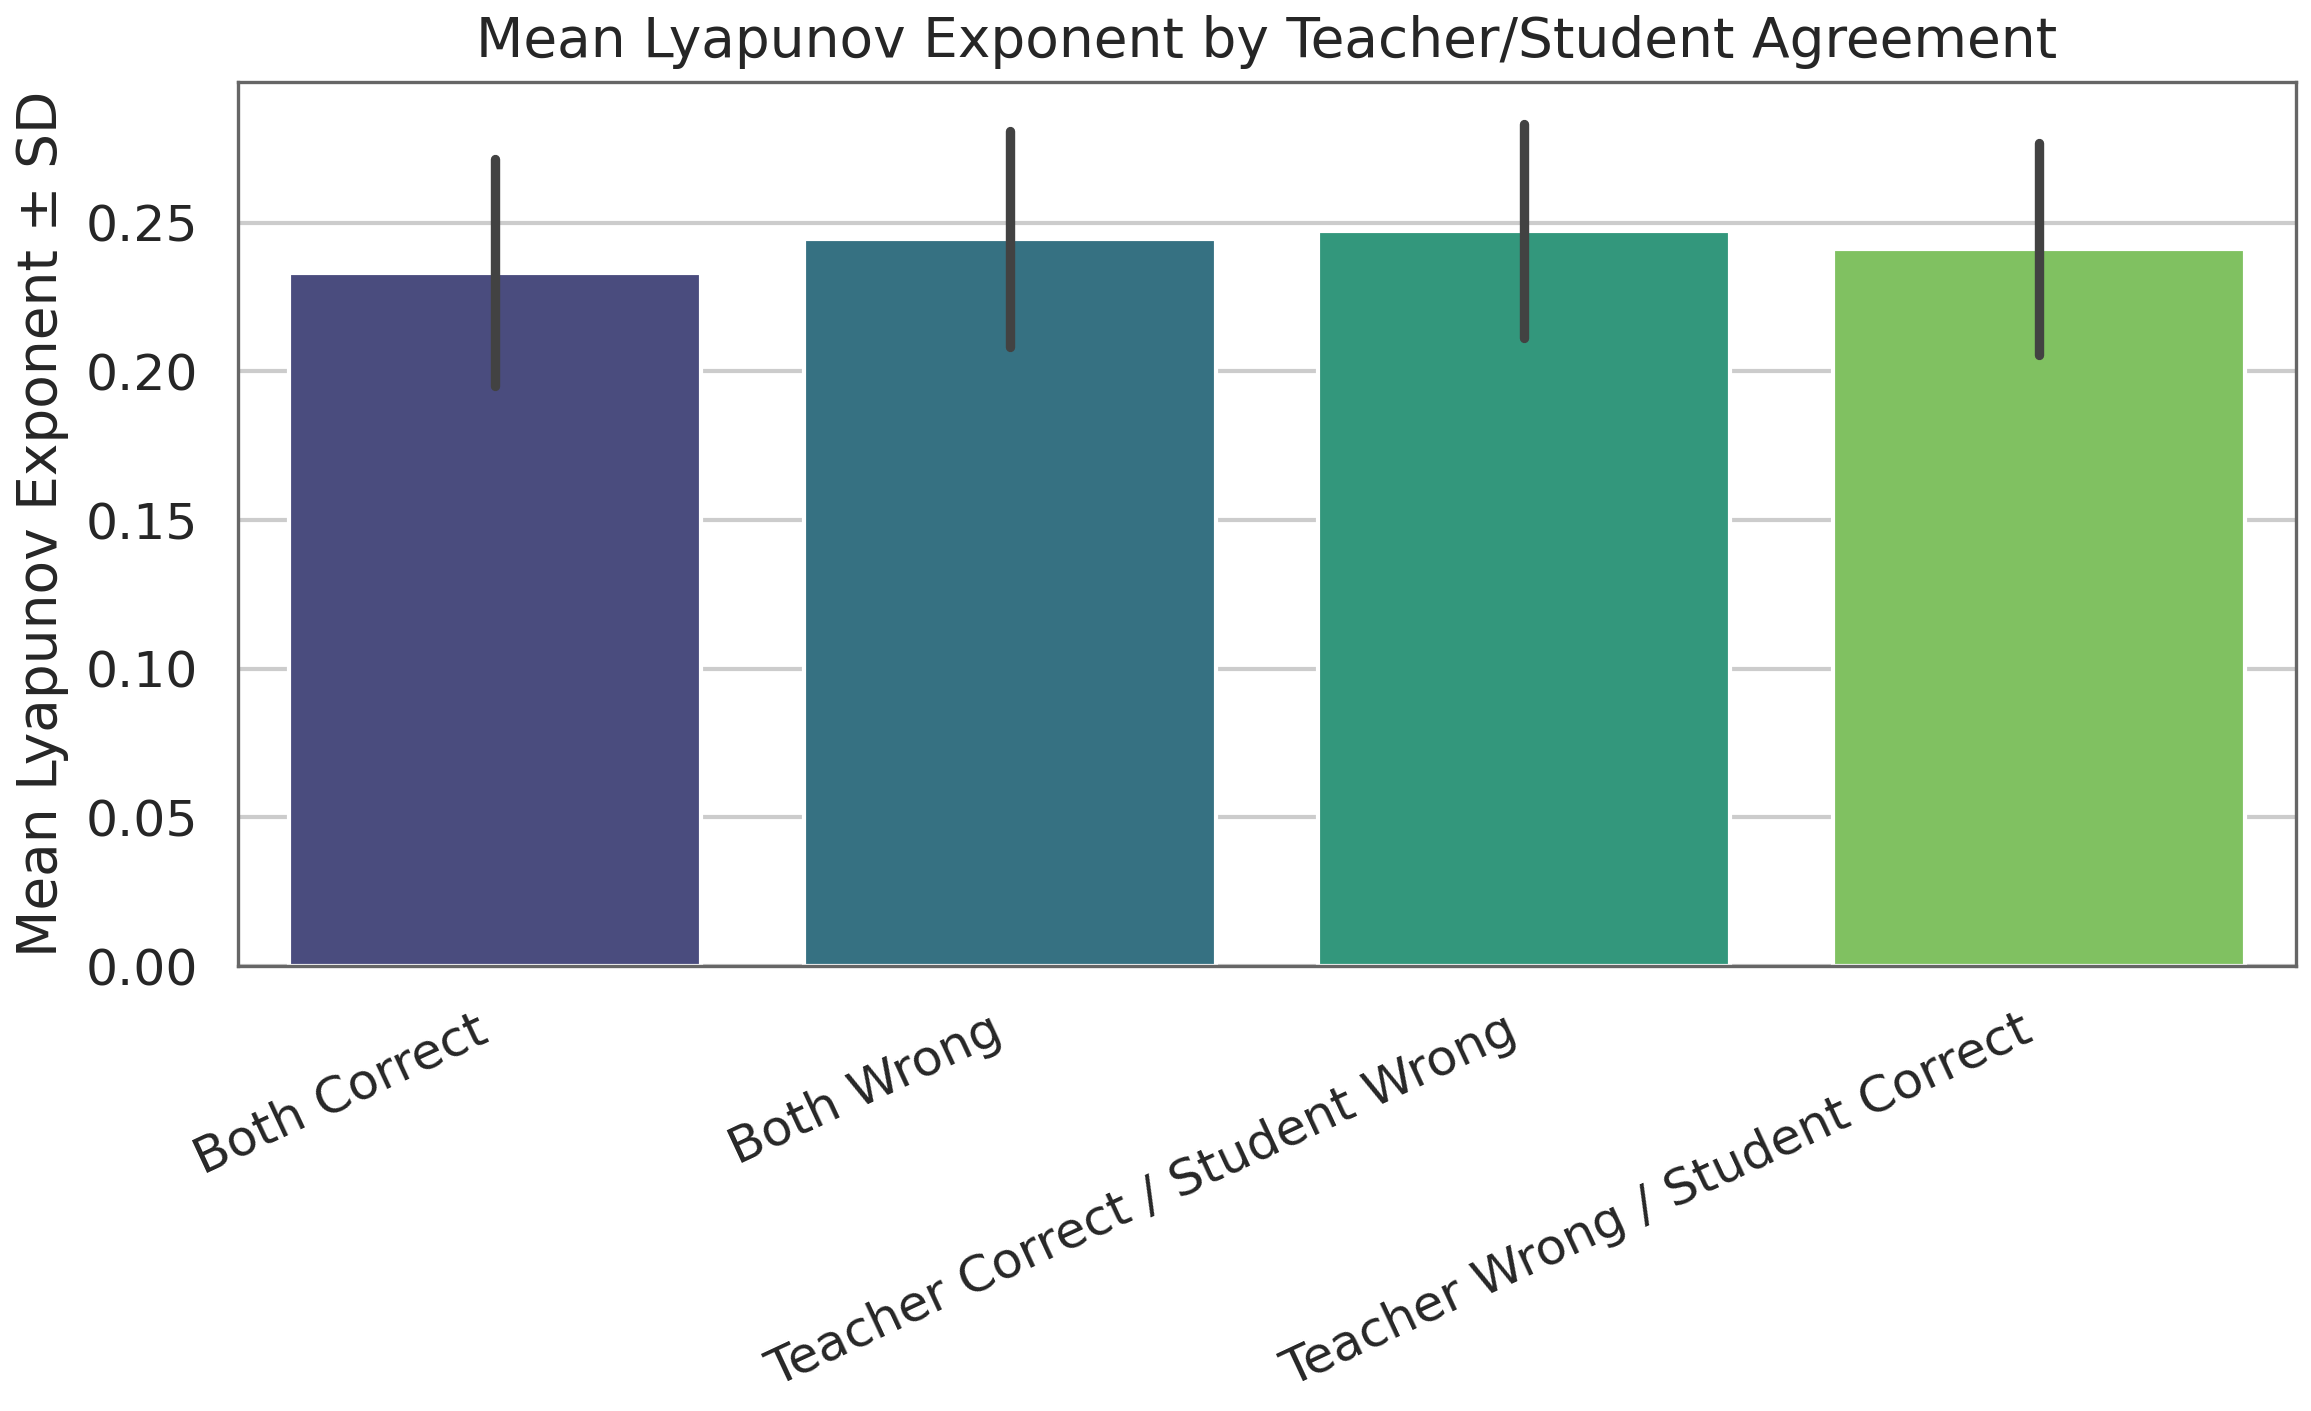

In [47]:
df_long["case"] = (
    df_long["teacher_correct"].astype(str) + "_" + df_long["correct"].astype(str)
)
case_map = {
    "True_True": "Both Correct",
    "True_False": "Teacher Correct / Student Wrong",
    "False_False": "Both Wrong",
    "False_True": "Teacher Wrong / Student Correct",
}
df_long["case_label"] = df_long["case"].map(case_map)

plt.figure(figsize=(8,5))
sns.barplot(data=df_long, x="case_label", y="lyap", palette="viridis", ci="sd")
plt.title("Mean Lyapunov Exponent by Teacher/Student Agreement")
plt.ylabel("Mean Lyapunov Exponent ± SD")
plt.xlabel("")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

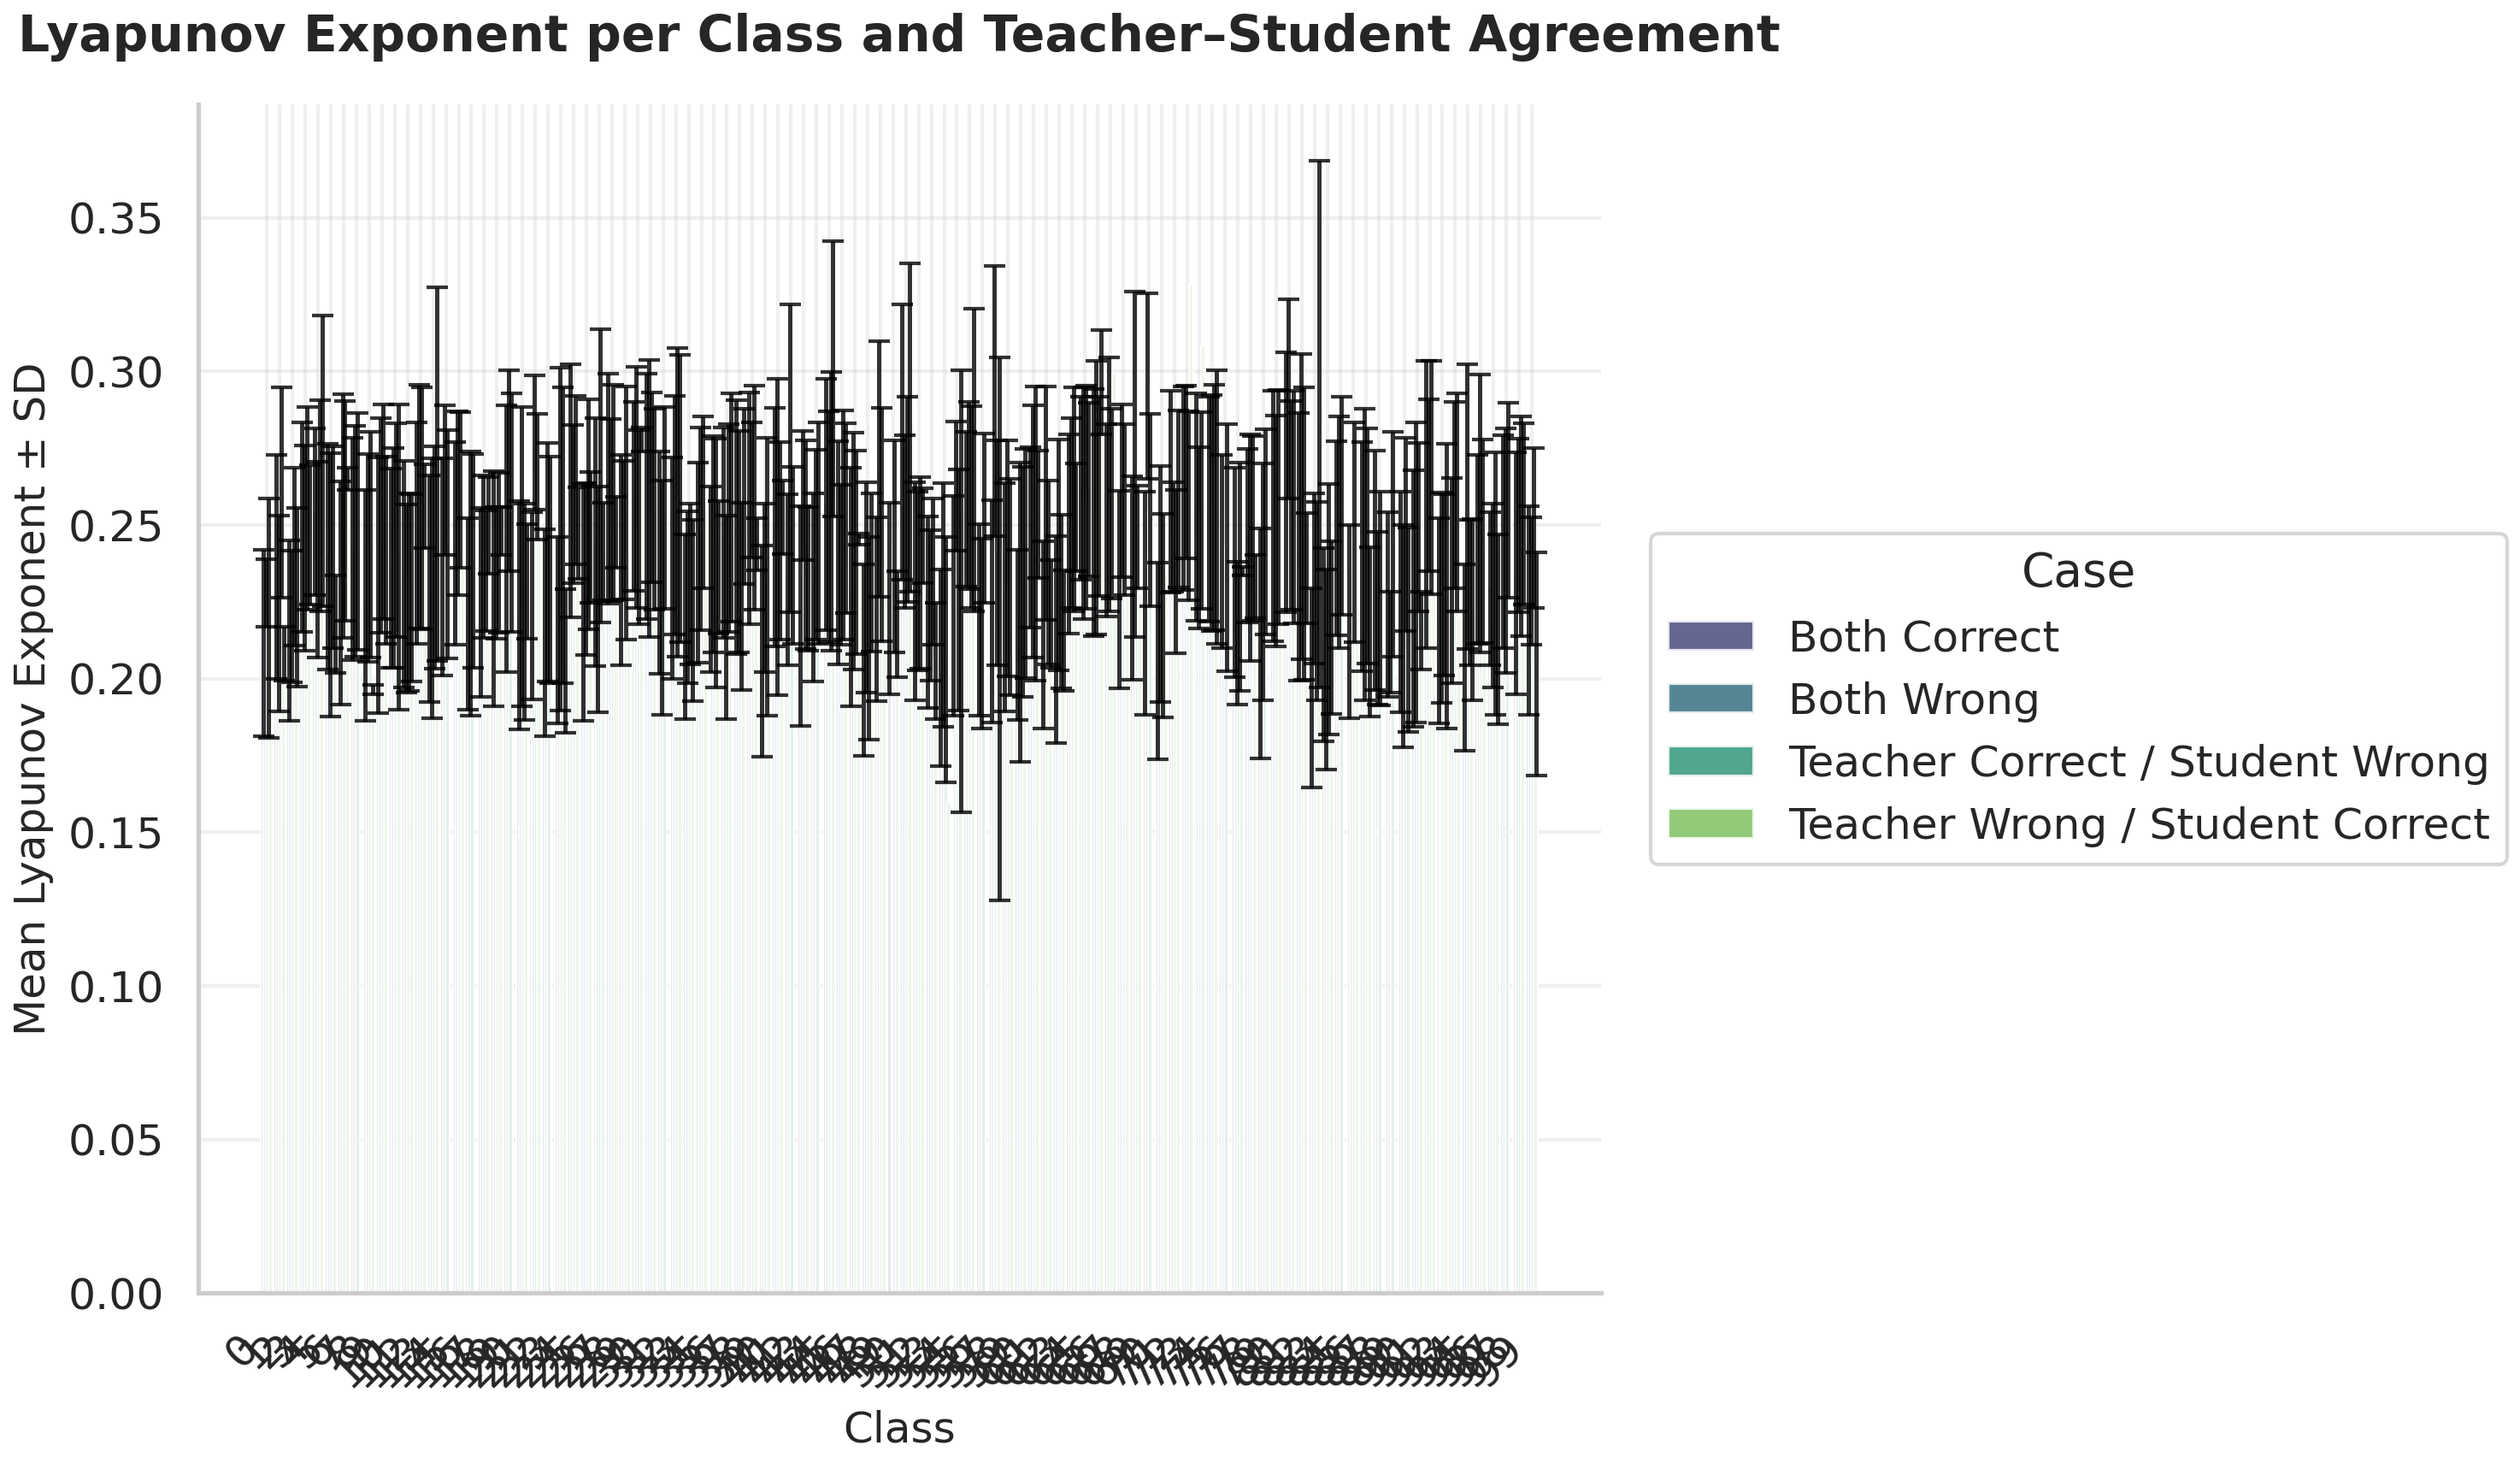

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Aggregate ---
agg_df = (
    df_long.groupby(["class", "case_label"])["lyap"]
    .agg(["mean", "std"])
    .reset_index()
)

# --- Plot setup ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12,6))

# --- Main grouped barplot (mean ± std) ---
ax = sns.barplot(
    data=agg_df,
    x="class", y="mean",
    hue="case_label",
    palette="viridis",
    errorbar=None,  # we’ll manually add std bars
    alpha=0.85
)

# --- Add std as error bars ---
for i, row in agg_df.iterrows():
    # find position of the bar
    x_pos = list(agg_df["class"].unique()).index(row["class"])
    hue_pos = list(agg_df["case_label"].unique()).index(row["case_label"])
    # manually get offset for grouped bars
    n_hues = agg_df["case_label"].nunique()
    bar_width = 0.8 / n_hues
    offset = (hue_pos - n_hues/2 + 0.5) * bar_width
    ax.errorbar(
        x_pos + offset, row["mean"],
        yerr=row["std"],
        fmt='none',
        ecolor='black',
        elinewidth=1.2,
        capsize=3,
        alpha=0.8
    )

# --- Aesthetics ---
ax.set_title(
    "Lyapunov Exponent per Class and Teacher–Student Agreement",
    fontsize=14, pad=15, weight="semibold"
)
ax.set_ylabel("Mean Lyapunov Exponent ± SD", fontsize=12)
ax.set_xlabel("Class", fontsize=12)
plt.xticks(rotation=45, ha="right")
ax.grid(alpha=0.3)
sns.despine()

# --- Legend outside ---
sns.move_legend(ax, "center left", bbox_to_anchor=(1.02, 0.5), frameon=True, title="Case")

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


/tmp/ipykernel_3315229/4275908705.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 0.97])


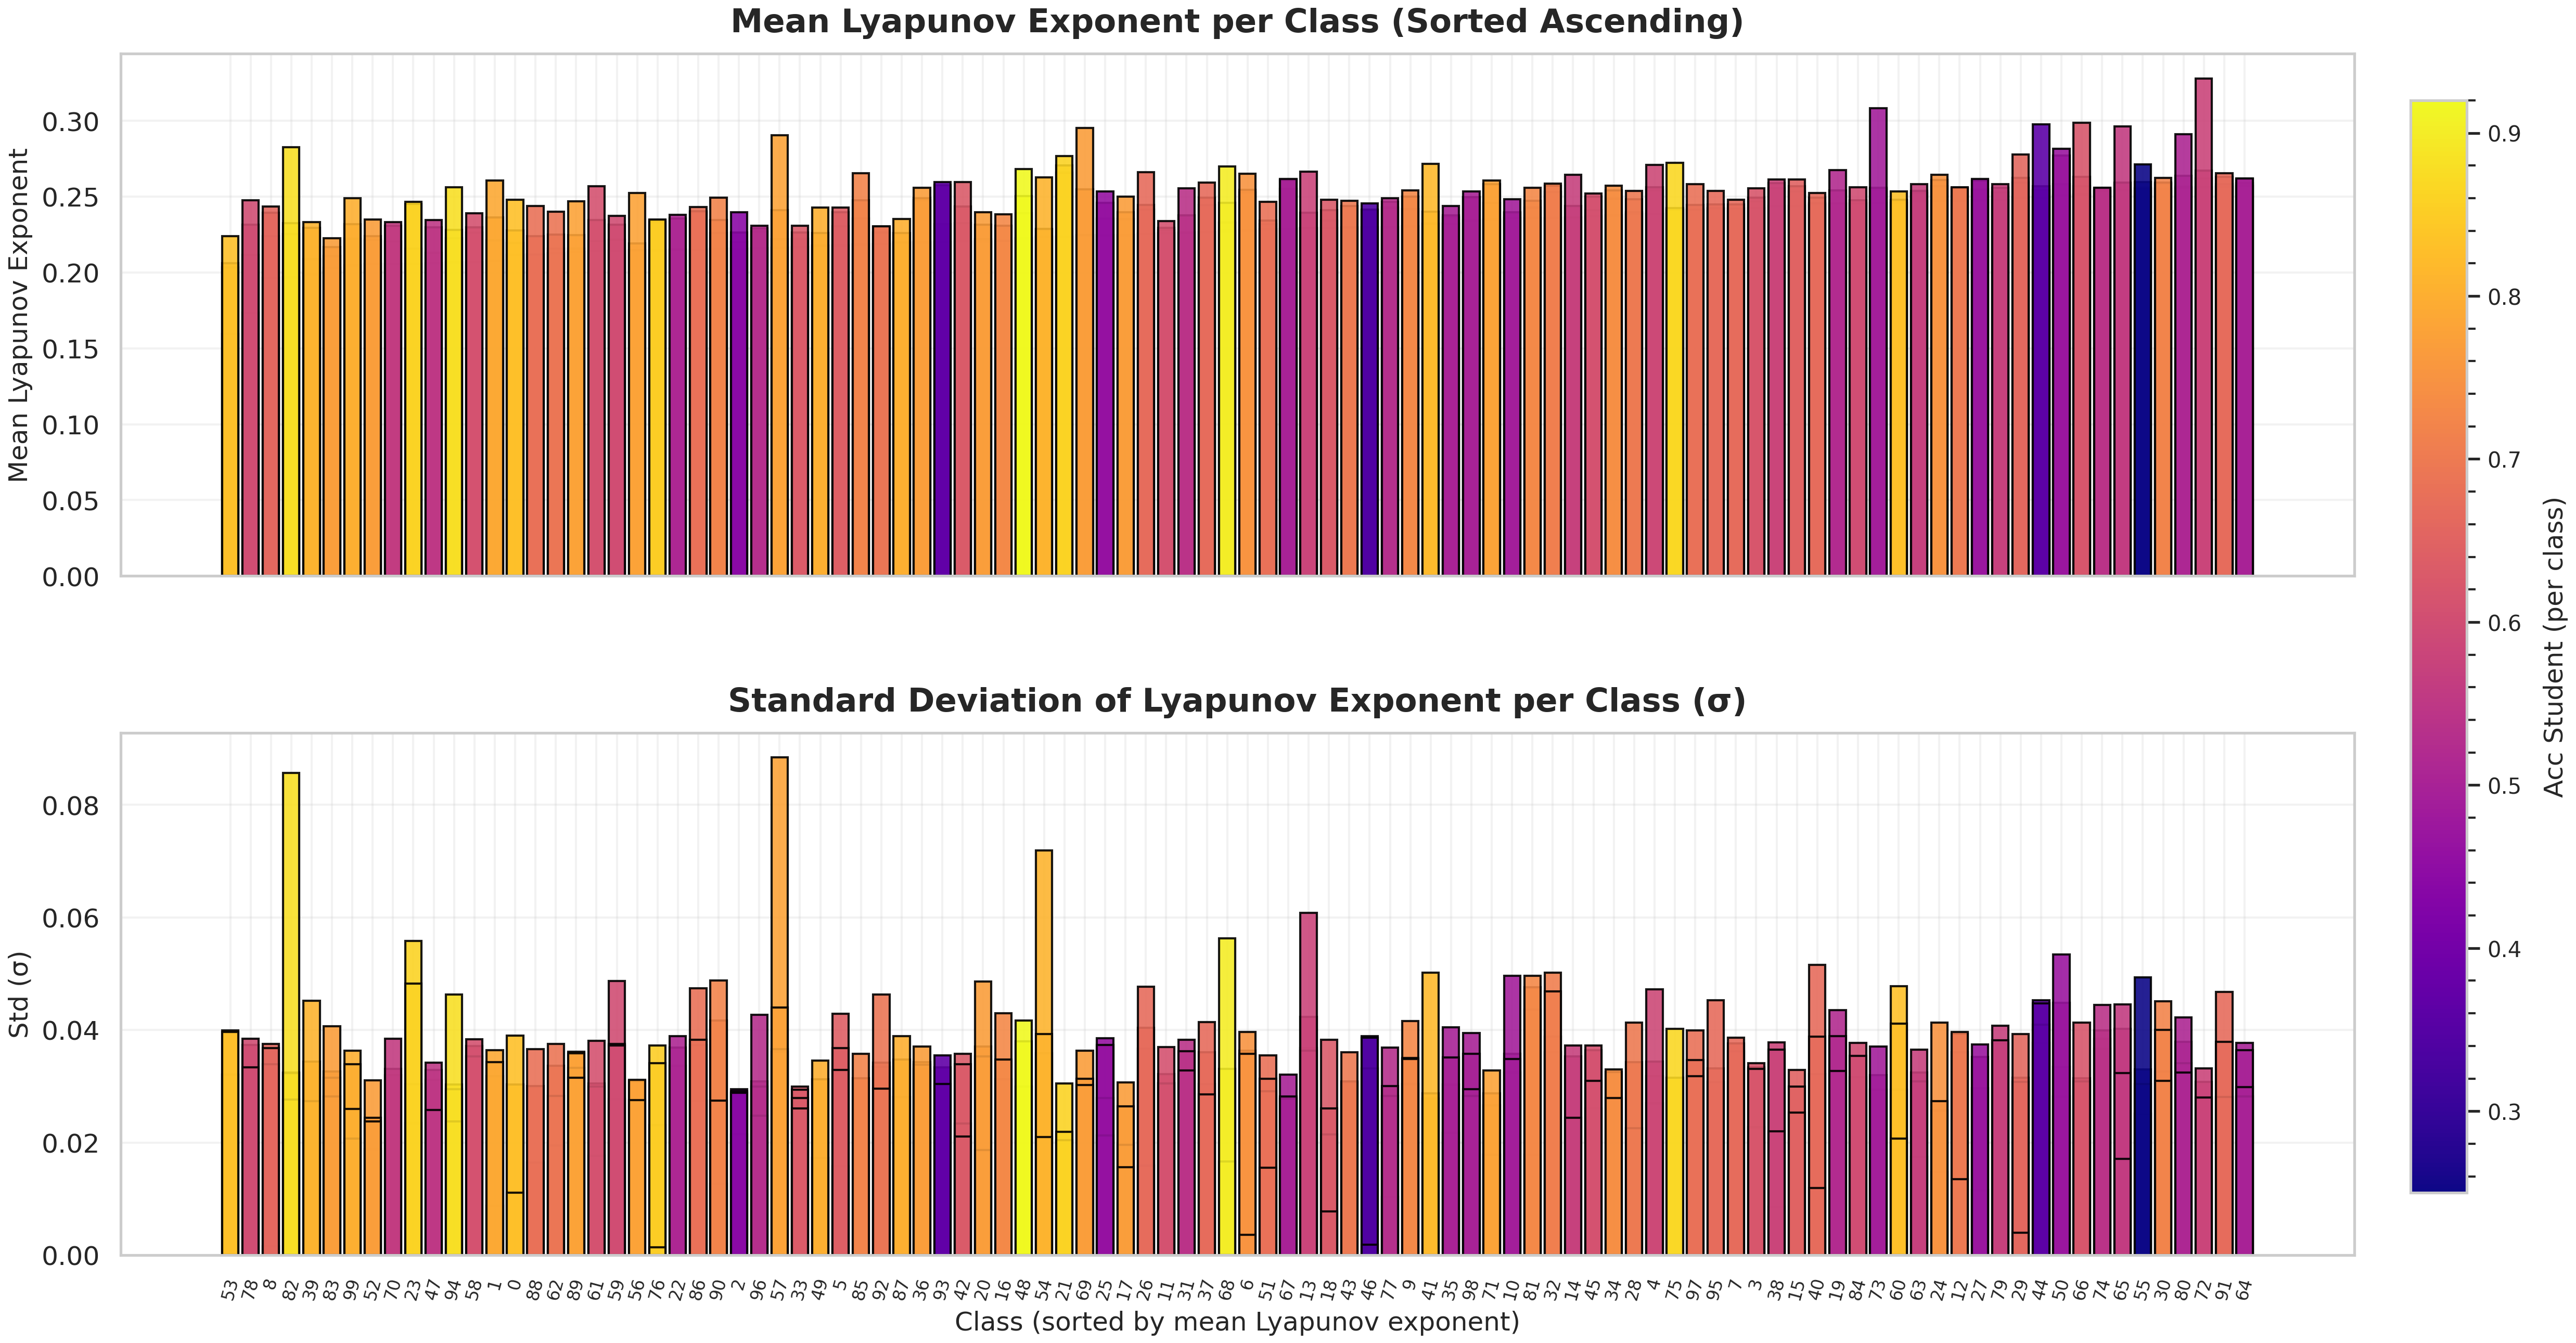

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data
agg_df["var"] = agg_df["std"]

# Sort globally by mean Lyapunov exponent
agg_df_sorted = agg_df.sort_values("mean", ascending=True)
class_order = agg_df_sorted["class"].unique()

# Merge with accuracy info
agg_df_merged = agg_df_sorted.merge(df[["class", "acc_student", "acc_teacher"]], on="class", how="left")
color_by = "acc_student"

# Normalize accuracy for colormap
norm = plt.Normalize(agg_df_merged[color_by].min(), agg_df_merged[color_by].max())
cmap = plt.cm.plasma   # bright & perceptually uniform
colors = cmap(norm(agg_df_merged[color_by].values))

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True,
                         gridspec_kw={"hspace": 0.3, "right": 0.92})  # leave room for colorbar

# --- Mean Lyapunov Exponent ---
axes[0].bar(
    agg_df_merged["class"].astype(str),
    agg_df_merged["mean"],
    color=colors,
    edgecolor="black",
    alpha=0.9
)
axes[0].set_title("Mean Lyapunov Exponent per Class (Sorted Ascending)",
                  fontsize=15, weight="bold", pad=10)
axes[0].set_ylabel("Mean Lyapunov Exponent", fontsize=12)
axes[0].grid(alpha=0.25)

# --- Variance (σ) ---
axes[1].bar(
    agg_df_merged["class"].astype(str),
    agg_df_merged["var"],
    color=colors,
    edgecolor="black",
    alpha=0.9
)
axes[1].set_title("Standard Deviation of Lyapunov Exponent per Class (σ)",
                  fontsize=15, weight="bold", pad=10)
axes[1].set_ylabel("Std (σ)", fontsize=12)
axes[1].set_xlabel("Class (sorted by mean Lyapunov exponent)", fontsize=12)
axes[1].grid(alpha=0.25)

# Rotate class labels
for ax in axes:
    ax.tick_params(axis="x", rotation=75, labelsize=8)

# --- Add colorbar outside the plots ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(f"{color_by.replace('_', ' ').title()} (per class)", fontsize=12, labelpad=10)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.93, 0.97])
plt.show()


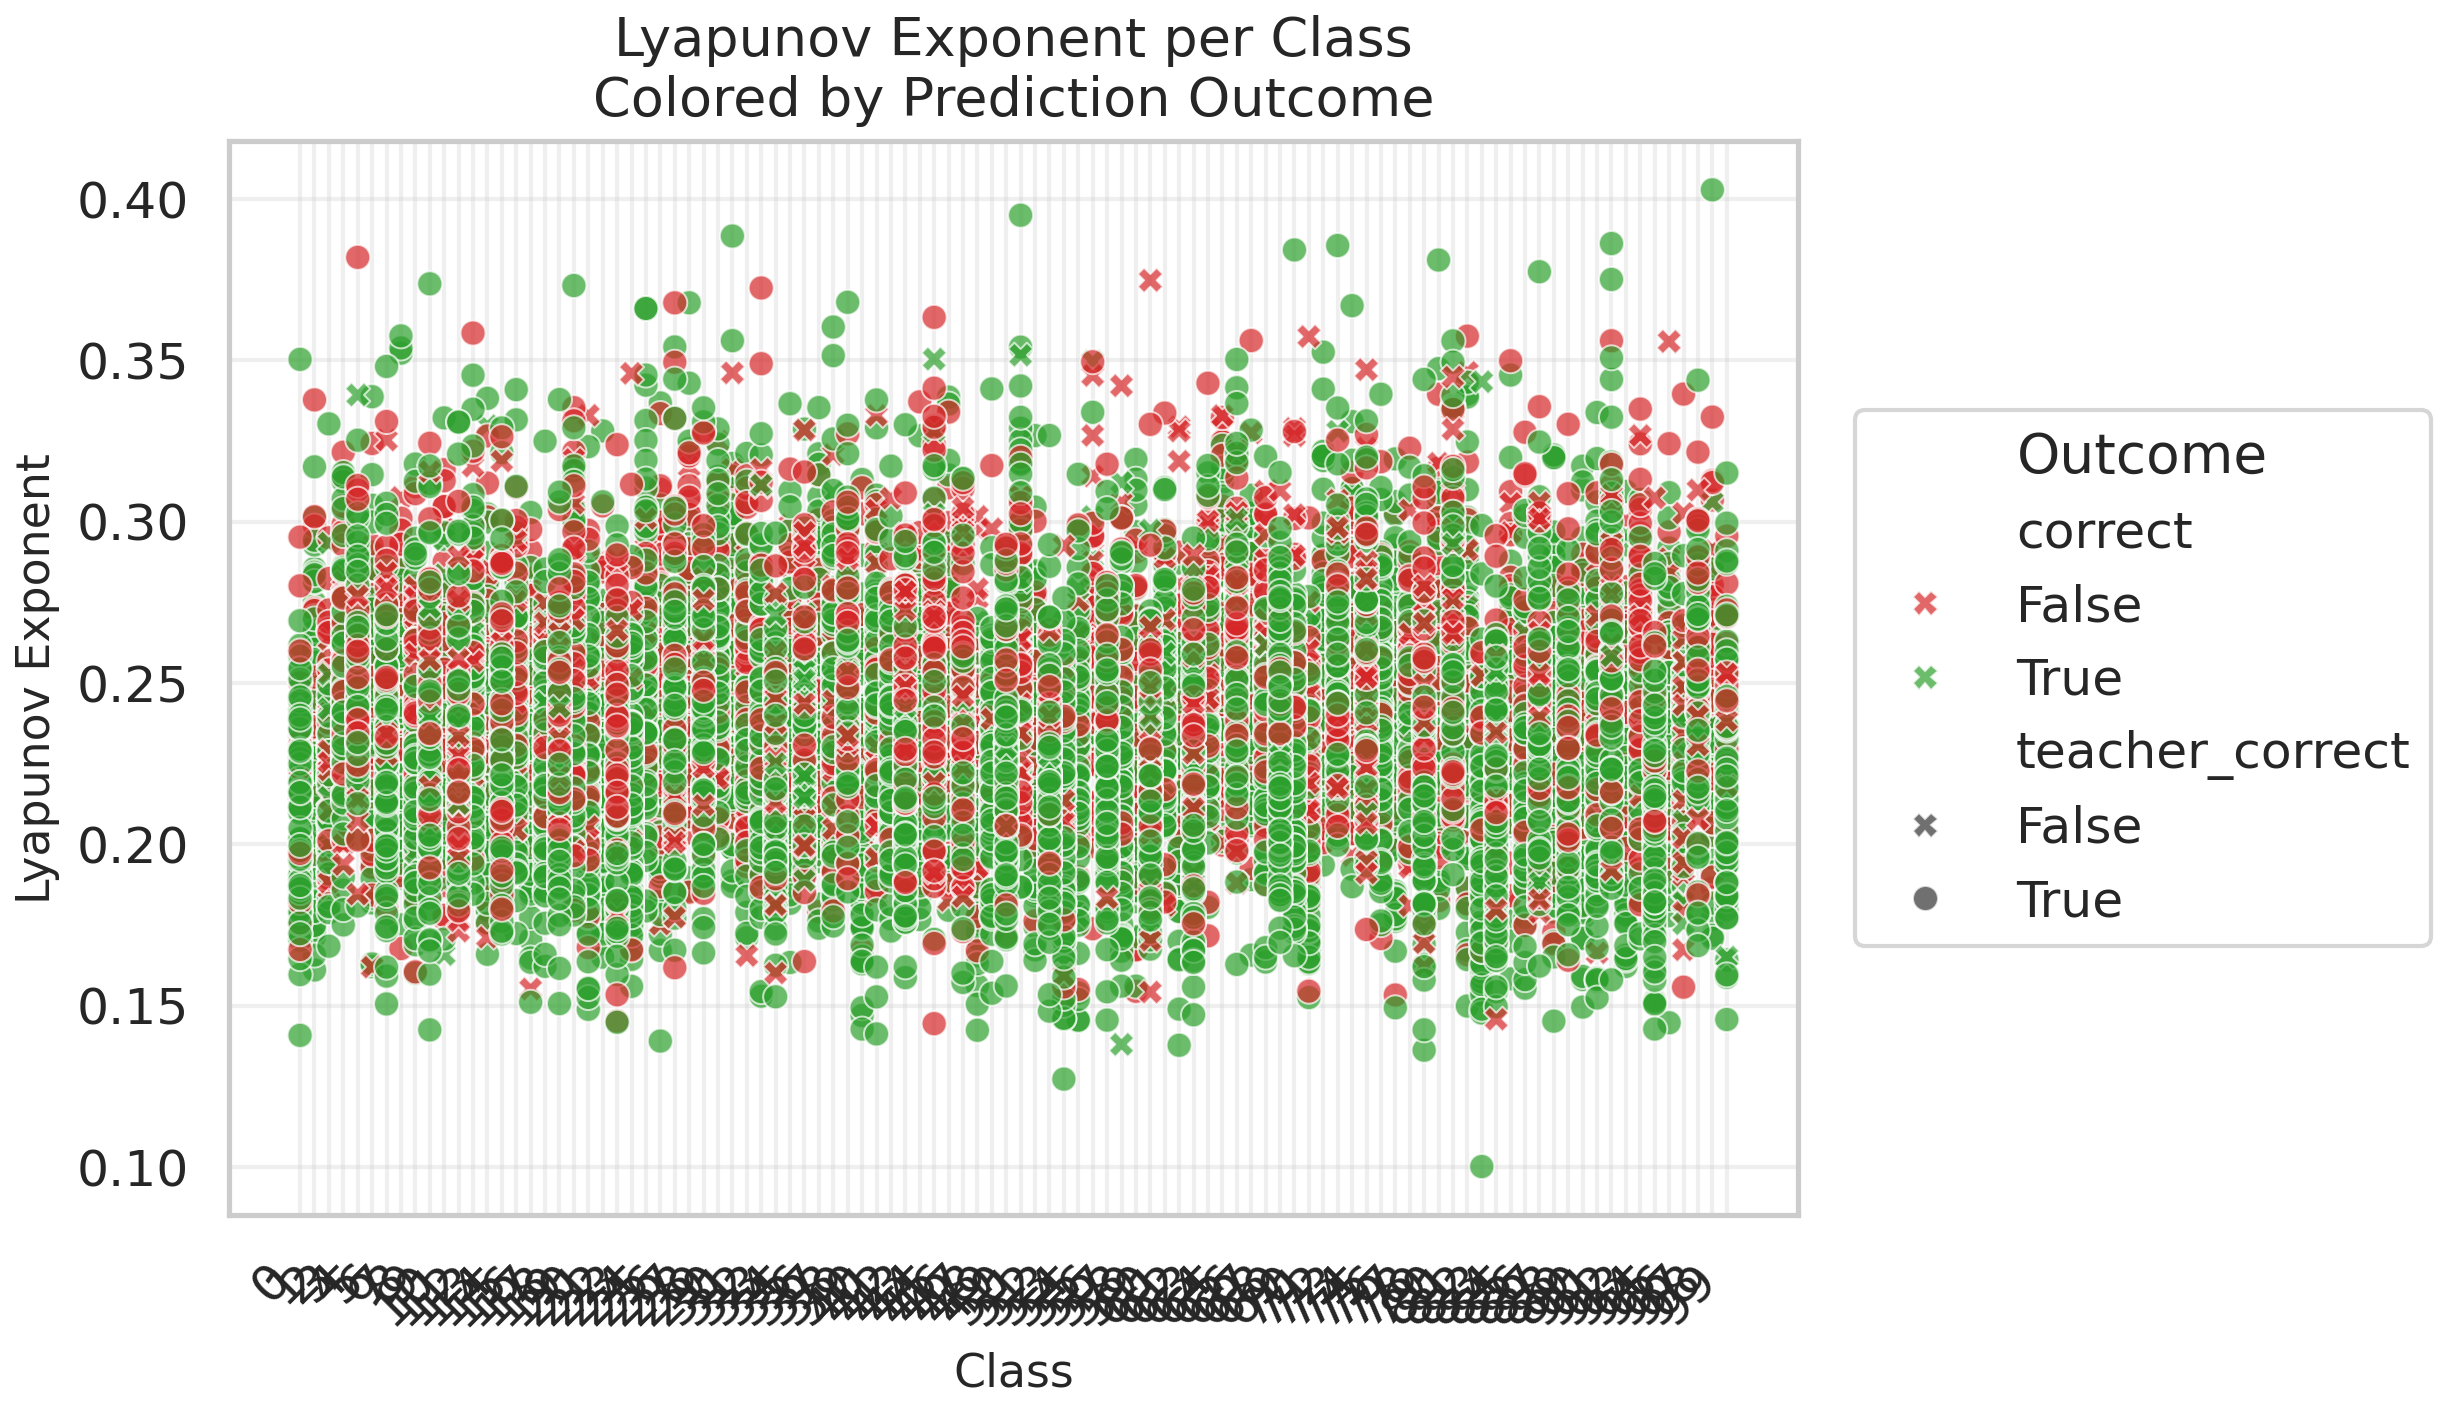

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = sns.scatterplot(
    data=df_long, 
    x="class", y="lyap", 
    hue="correct", style="teacher_correct",     markers={True: "o", False: "X"},              # circle = correct, X = wrong
    palette={True: "#2ca02c", False: "#d62728"}, alpha=0.7
)

# Show all class labels on x-axis (sorted)
all_classes = sorted(df_long["class"].unique())
ax.set_xticks(range(len(all_classes)))
ax.set_xticklabels(all_classes, rotation=45, ha="right")

# Title and labels
ax.set_title("Lyapunov Exponent per Class\nColored by Prediction Outcome", fontsize=13)
ax.set_ylabel("Lyapunov Exponent", fontsize=11)
ax.set_xlabel("Class", fontsize=11)

# ✅ Move legend outside
sns.move_legend(ax, "center left", bbox_to_anchor=(1.02, 0.5), frameon=True, title="Outcome")

# Improve layout
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(alpha=0.3)
plt.show()


